In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import time
import random
import igraph as ig
import ConfigModel_MCMC as CM
import networkx as nx
import statistics
from multiprocessing import Process
from itertools import combinations
from random import sample
import itertools
import scipy as sp
import pickle

In [2]:
class Node():
    def __init__(self, label='', edges=[]):
        self.label = label
        self.edges = edges

In [3]:
class DynaNet():
    def __init__(self, structure = '', adj_mtx = [], adj_lst = []):
        '''
        structure: if predifined structure, it will generate such structure.(future iterations)
        adj_mtx: Adjacency matrix if available
        adj_lst: Adjacency List as a dictionary
        '''
        if adj_mtx == []:
            self.adj_lst =  adj_lst
            self.adj_mtx = np.zeros()
            for i in adj_lst.keys():
                for j in adj_lst[i]:
                    self.adj_mtx[i, j] = 1
        else:
            self.adj_mtx = adj_mtx
        
        self.vert = [i for i in range(0, adj_mtx.shape[0])]
        self.edge = []
        for i in self.vert:
            for j in range(i, self.adj_mtx.shape[1]):
                if self.adj_mtx[i,j] == 1:
                    self.edge += [[i,j]]
    
    def generate_incidence(self):
        
        self.incidence_mtx = np.zeros([len(self.vert), len(self.edge)])
        for e in range(0, len(self.edge)):
            self.incidence_mtx[ min(self.edge[e]),  e] = 1
            self.incidence_mtx[ max(self.edge[e]),  e] = -1

    def graph_gradient(self):
        '''
        returns adjacency like matrix that is the gradient of each vetice
        '''
        self.grad_mtx = np.zeros(self.adj_mtx.shape)
        
        for e in self.edge:
            self.grad_mtx[e[0], e[0]] += 1
            self.grad_mtx[e[0], e[1]] = -1
            self.grad_mtx[e[1], e[1]] += 1
            self.grad_mtx[e[1], e[0]] = -1
        
        
    def dynamic_euler(self, df, f0, t0, tf, nt):
        '''
        df: function of f' takes in a incidence matrix, gradient matrix a state i, and a time t returns derivative
        f0: Initial value
        t0: initial time
        tf: final time
        nt: Number of steps
        '''
        
        self.generate_incidence()
        self.graph_gradient()
        K = self.incidence_mtx
        Glag = np.dot(K, np.transpose(K))
        Ggrad = self.grad_mtx

        t = np.linspace(t0, tf, nt)
        dt = (tf-t0)/nt
        f = np.zeros([self.adj_mtx.shape[0], len(t)])
        f[:,0] = f0

        for i in range(1, len(t)):
            print('time step.... ', i, end = '\r')
            f[:, i] = f[:,i-1] + dt*df(Glag, Ggrad, f[:,i-1],t[i-1])
            # f[:, i] = np.clip(f[:,i], 0, +50)
            f[:, i] = np.maximum(np.zeros(len( f[:, i])), f[:,i])
        self.dynamic = f
            

In [4]:
np.maximum(np.array([0,0]), np.array([-1,1]))

array([0, 1])

In [5]:
def ADE(Glag, Ggrad, f, D, v):
    '''
    GLag: graph Laplacian
    Ggrad: graph gradient
    f: state 
    D: vector ofdiffusion coefficient.
    v: velocity the tension is moving by.
    '''
    Dxf = np.multiply(D, f)
    gradf = np.dot(Ggrad, f)
    df = np.dot(Glag, Dxf) - np.multiply(v, gradf)
    
    return df

In [6]:
A = np.array([[0,1,0],
              [1,0,1],
              [0,1,0]
             ])

Netwk = DynaNet(adj_mtx = A)

D = np.array([0.65 for i in Netwk.vert])
v = np.array([-0.4 for i in Netwk.vert])


def ADE_for_graph(Glag, Ggrad, f, t):
    return ADE(Glag, Ggrad, f, D, v)

f0 = [np.exp(-(i-1)**2) for i in Netwk.vert]
t0 = 0
tf = 10
nt = 1000

t = np.linspace(t0, tf, nt)

Netwk.dynamic_euler(ADE_for_graph, f0, t0, tf, nt)


C:\Users\yassin\AppData\Local\Temp\ipykernel_3268\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


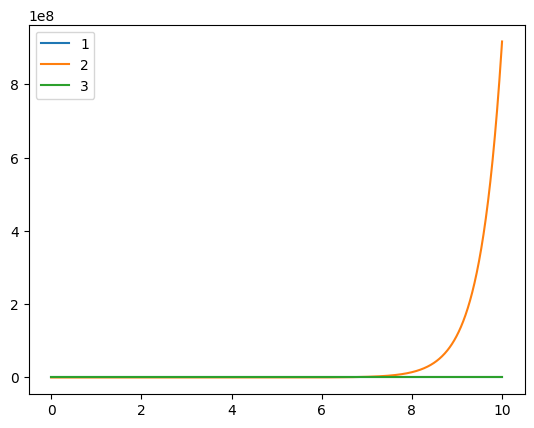

In [7]:
plt.plot(t, Netwk.dynamic[0,:], label = '1')
plt.plot(t, Netwk.dynamic[1,:], label = '2')
plt.plot(t, Netwk.dynamic[2,:], label = '3')
plt.legend()
plt.show()

In [8]:
A = np.array([[0,1,0,0,0,0],
              [1,0,1,1,1,0],
              [0,1,0,0,0,0],
              [0,1,0,0,0,0],
              [0,1,0,0,0,1],
              [0,0,0,0,1,0],
             ])



Netwk = DynaNet(adj_mtx = A)

D = np.array([-0.65 for i in Netwk.vert])
v = np.array([-0.4 for i in Netwk.vert])


def ADE_for_graph(Glag, Ggrad, f, t):
    return ADE(Glag, Ggrad, f, D, v)

# f0 = [i for i in Netwk.vert]

f0 = [ 1, 20, 10, 1, 1, 1 ]
t0 = 0
tf = 25
nt = 1000

t = np.linspace(t0, tf, nt)

Netwk.dynamic_euler(ADE_for_graph, f0, t0, tf, nt)


C:\Users\yassin\AppData\Local\Temp\ipykernel_3268\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


In [9]:
Netwk.dynamic[:,0]

array([ 1., 20., 10.,  1.,  1.,  1.])

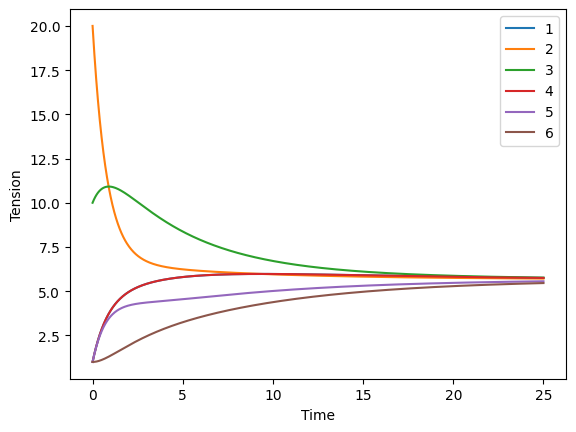

In [10]:
plt.plot(t, Netwk.dynamic[0,:], label = '1')
plt.plot(t, Netwk.dynamic[1,:], label = '2')
plt.plot(t, Netwk.dynamic[2,:], label = '3')
plt.plot(t, Netwk.dynamic[3,:], label = '4')
plt.plot(t, Netwk.dynamic[4,:], label = '5')
plt.plot(t, Netwk.dynamic[5,:], label = '6')
plt.xlabel('Time')
plt.ylabel('Tension')
plt.legend()
plt.show()

In [11]:
max(Netwk.dynamic[3,:])

5.975107429319

In [12]:
A = np.array([[0,1,1,0,0],
              [1,0,1,1,0],
              [1,1,0,0,0],
              [0,1,0,0,1],
              [0,0,0,1,0],
             ])

Netwk = DynaNet(adj_mtx = A)

D = np.array([-0.65 for i in Netwk.vert])
v = np.array([-0.4 for i in Netwk.vert])
def R(x):
    return 0.1*np.cos(x)
def R(x,f0):
    return 0.05*np.cos(x)*f0

def ADE_for_graph_withR(Glag, Ggrad, f, t):
    return ADE(Glag, Ggrad, f, D, v) + np.array([f[i]*R(t) for i in range(0,len(f)) ])

# f0 = [i for i in Netwk.vert]

f0 = np.array([ 4, 1, 1, 2, 5 ])
t0 = 0
tf = 50
nt = 10000
def ADE_for_graph_withRf0(Glag, Ggrad, f, t):
    return ADE(Glag, Ggrad, f, D, v) + R(t, f0) 
t = np.linspace(t0, tf, nt)

Netwk.dynamic_euler(ADE_for_graph_withRf0, f0, t0, tf, nt)


C:\Users\yassin\AppData\Local\Temp\ipykernel_3268\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


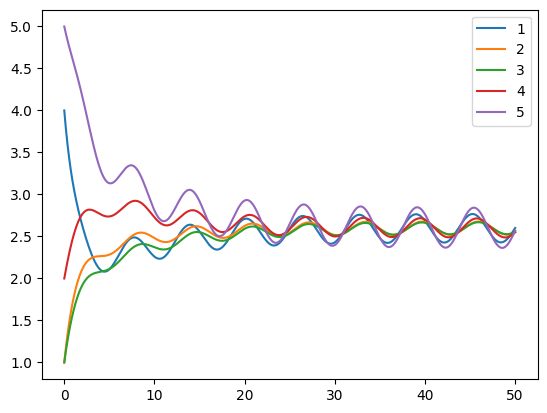

array([0.10806046, 0.02701512, 0.02701512, 0.05403023, 0.13507558])

In [13]:
plt.plot(t, Netwk.dynamic[0,:], label = '1')
plt.plot(t, Netwk.dynamic[1,:], label = '2')
plt.plot(t, Netwk.dynamic[2,:], label = '3')
plt.plot(t, Netwk.dynamic[3,:], label = '4')
plt.plot(t, Netwk.dynamic[4,:], label = '5')
plt.legend()
plt.show()

R(1, f0)

## 2 - $ \partial_t f = D\Delta f + f(1-f)$

In [14]:
def DE(Glap, Ggrad, f, D, v=0):
    '''
    GLag: graph Laplacian
    Ggrad: graph gradient
    f: state 
    D: vector ofdiffusion coefficient.
    v: velocity the tension is moving by.
    '''
    Dxf = np.multiply(D, f)

    df = np.dot(Glap, Dxf) + np.multiply(f, 1-f) #+ np.array(np.random.normal(0, 1, size = f.shape[0]))
    
    return df

In [15]:
graphlap =np.dot(Netwk.incidence_mtx, np.transpose(Netwk.incidence_mtx))
0.65*np.dot(graphlap,f0) + np.multiply(f0, 1-f0)

array([ -8.1 ,  -2.6 ,  -1.95,  -3.3 , -18.05])

In [16]:
A = np.array([[0,1,0,0,0,0],
              [1,0,1,1,1,0],
              [0,1,0,0,0,0],
              [0,1,0,0,0,0],
              [0,1,0,0,0,1],
              [0,0,0,0,1,0],
             ])

Netwk = DynaNet(adj_mtx = A)

D = np.array([-0.65 for i in Netwk.vert])
v = np.array([-0.4 for i in Netwk.vert])
def R(x):
    return 0.1*np.cos(x)
def R(x,f0):
    return 0.05*np.cos(x)*f0

def DE_for_graph_withR(Glag, Ggrad, f, t):
    return DE(Glag, Ggrad, f, D, v) #+ np.array([f[i]*R(t) for i in range(0,len(f)) ])

# f0 = [i for i in Netwk.vert]

f0 = np.array([ 10,20]+[0 for i in range(1,5)])
t0 = 0
tf = 100
nt = 100

t = np.linspace(t0, tf, nt)

Netwk.dynamic_euler(DE, f0, t0, tf, nt)


C:\Users\yassin\AppData\Local\Temp\ipykernel_3268\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


In [17]:
Netwk.dynamic[0,:]

array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

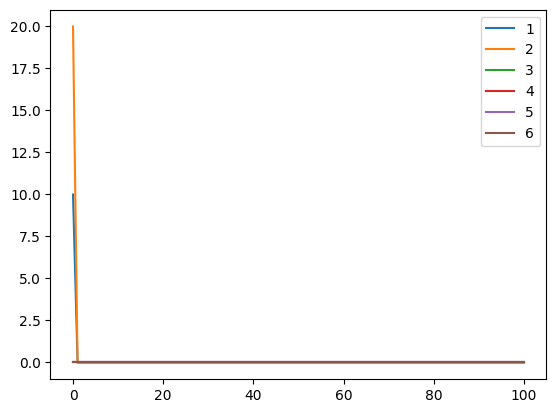

In [18]:
plt.plot(t, Netwk.dynamic[0,:], label = '1')
plt.plot(t, Netwk.dynamic[1,:], label = '2')
plt.plot(t, Netwk.dynamic[2,:], label = '3')
plt.plot(t, Netwk.dynamic[3,:], label = '4')
plt.plot(t, Netwk.dynamic[4,:], label = '5')
plt.plot(t, Netwk.dynamic[5,:], label = '6')
plt.legend()
plt.show()

## Big Netorks:


In [63]:
G2 = nx.erdos_renyi_graph(100,0.5)
ADJ = nx.to_numpy_array(G2)
Netwk = DynaNet(adj_mtx = ADJ)

D = np.array([0.5 for i in Netwk.vert])
v = np.array([-0.4 for i in Netwk.vert])
def R(x):
    return 0.1*np.cos(x)
def R(x,f0):
    return 0.05*np.cos(x)*f0

def DE_for_graph_withR(Glag, Ggrad, f, t):
    return DE(Glag, Ggrad, f, D)

# f0 = [i for i in Netwk.vert]

f0 = np.array(np.random.normal(0, 1, size = ADJ.shape[0]))
t0 = 0
tf = 50
nt = 1000
def DE_for_graph_withRf0(Glag, Ggrad, f, t):
    return DE(Glag, Ggrad, f, D) + R(t,f0)
t = np.linspace(t0, tf, nt)

Netwk.dynamic_euler(DE_for_graph_withRf0, f0, t0, tf, nt)


C:\Users\yassin\AppData\Local\Temp\ipykernel_19544\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


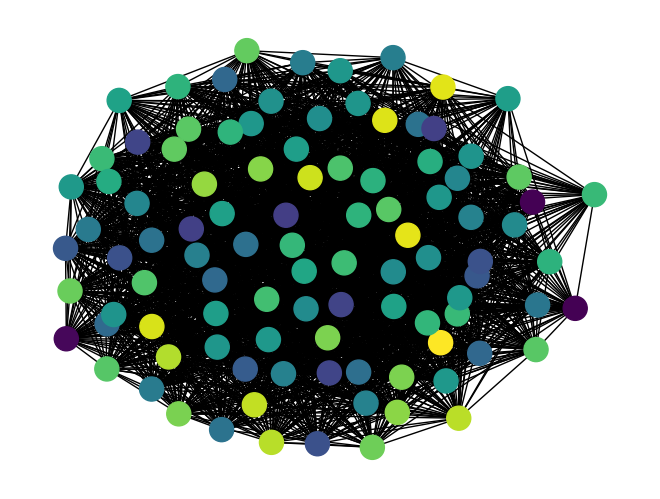

In [68]:
nx.draw(G2,  node_color = Netwk.dynamic[:,0]/np.linalg.norm( Netwk.dynamic[:,0]) )

# Graphing ER:

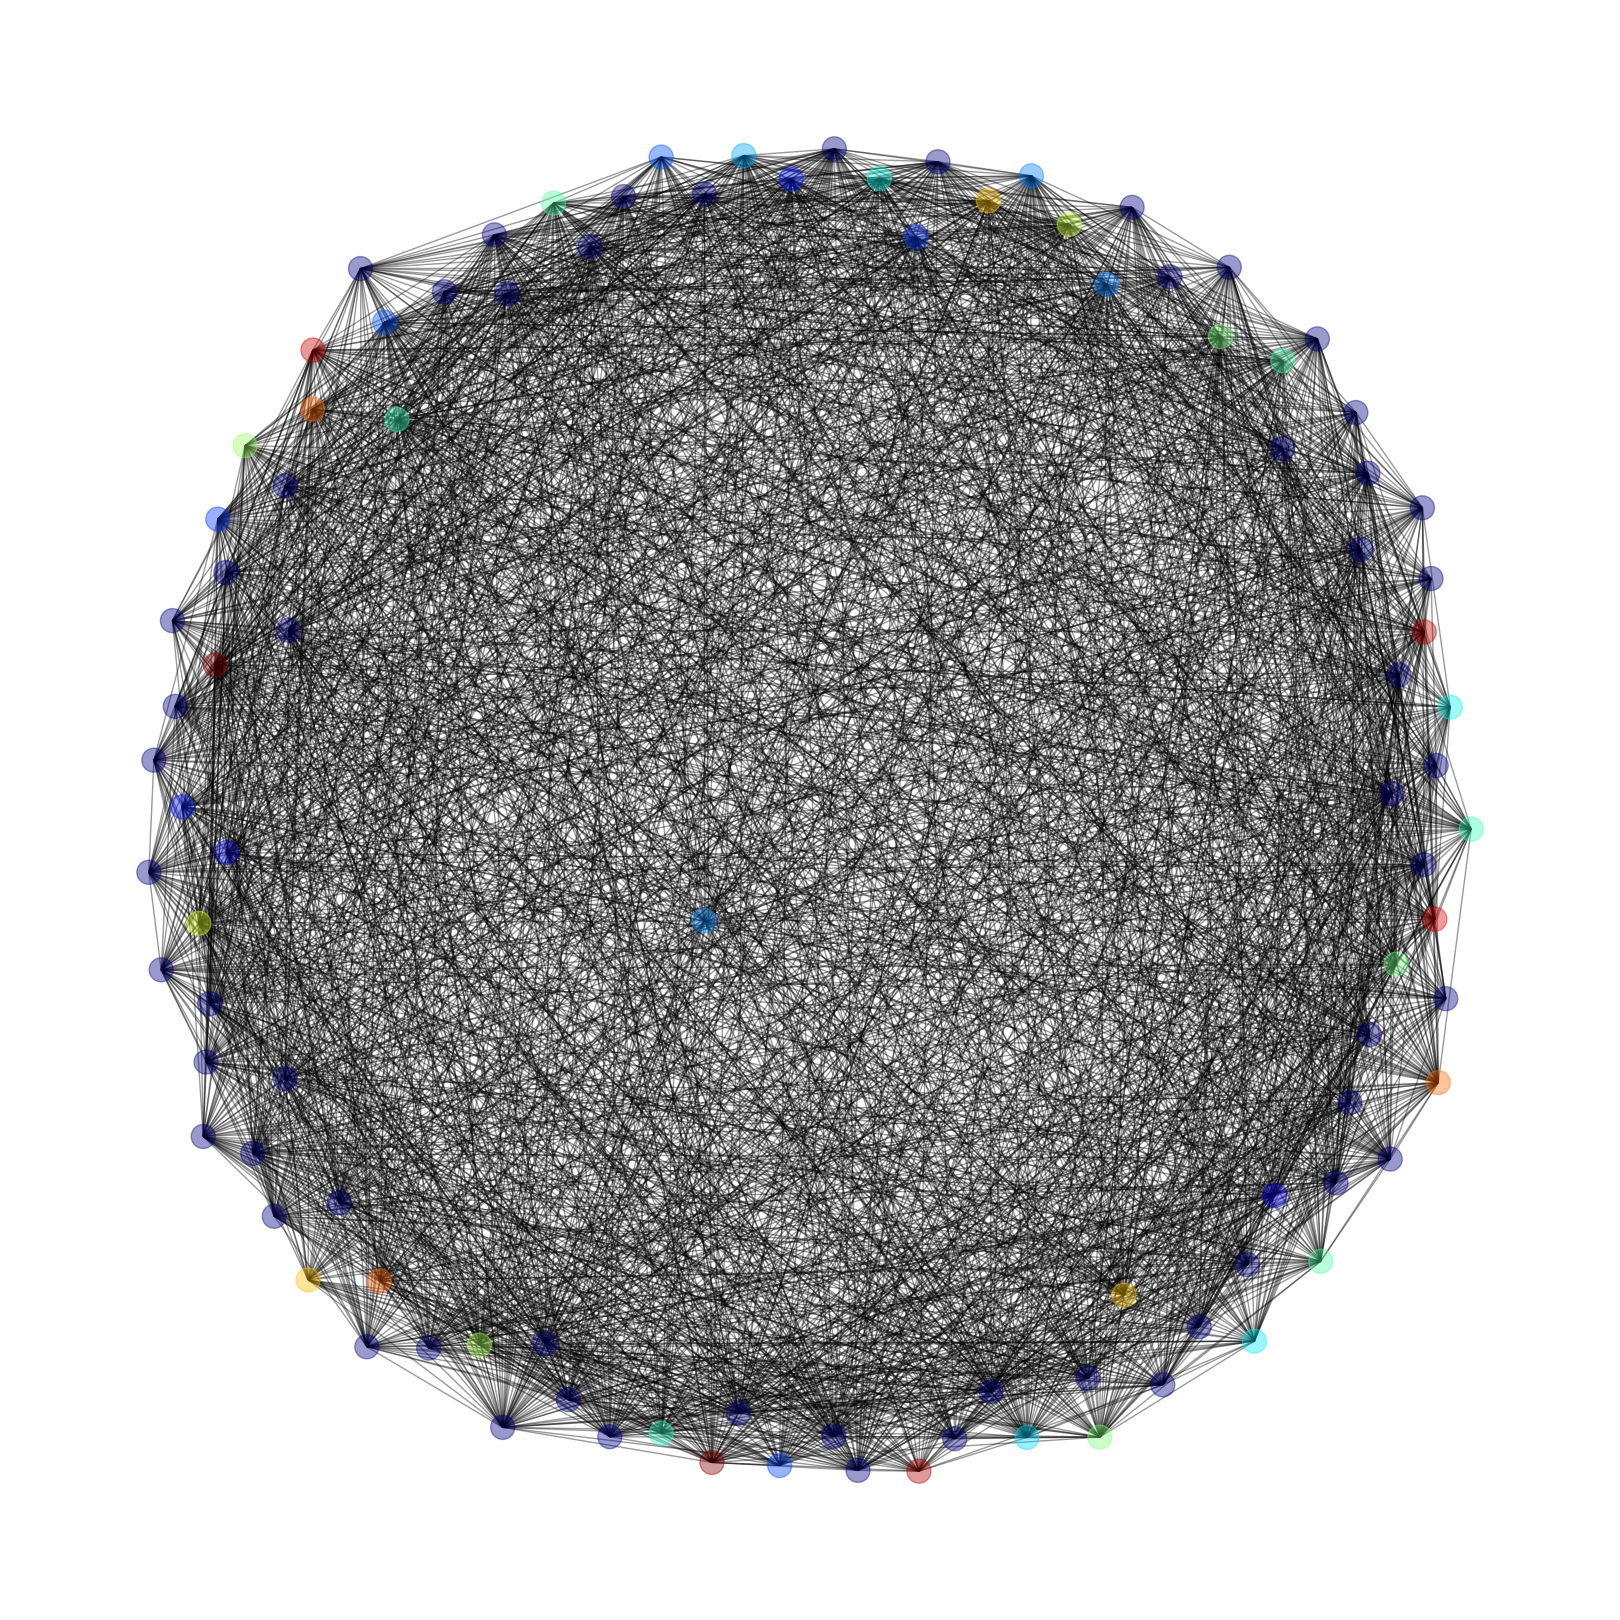

In [71]:
# (other code above this line)
#
plt.figure(figsize=(16,16))

# node colors

values = Netwk.dynamic[:,1]


# Nodes layout/ position
fixed_positions = {0:(0,0)}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G2,pos=fixed_positions, fixed = fixed_nodes, k=15)
# pos = nx.circular_layout(G, scale=2)

node_sizes = [1000] + [200]*283

nx.draw(G, cmap=plt.get_cmap('jet'), node_color=values,
        alpha=0.4, 
               pos=pos)


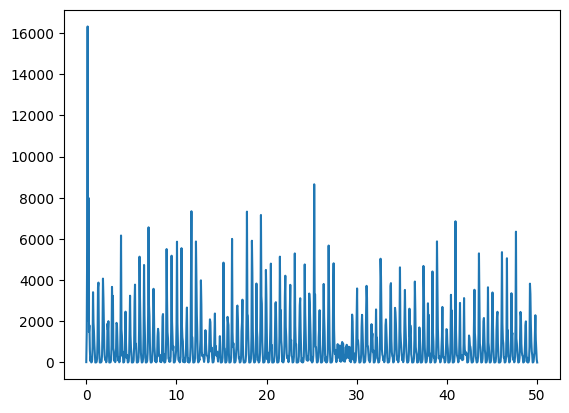

In [20]:
plt.plot(t, Netwk.dynamic.sum(axis =0))

#  Checking Diferent graphs:

### Erdos Reyni Graps:



In [270]:
sizes = [100]#, 500, 1000, 2500]
p_lst = [0.1, 0.5, 0.75, 0.9]
Diff = [0.1,0.25, 0.5, 0.75, 0.9]

In [15]:
def DE(Glap, Ggrad, f, D):
    '''
    GLag: graph Laplacian
    Ggrad: graph gradient
    f: state 
    D: vector ofdiffusion coefficient.
    v: velocity the tension is moving by.
    '''
    Dxf = np.multiply(D, f)
    gradf = np.dot(Ggrad, f)
    df = np.dot(Glap, Dxf) + np.multiply(f, 1-f)
    
    return df

1000 0.1 0.1


C:\Users\yassin\AppData\Local\Temp\ipykernel_11200\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


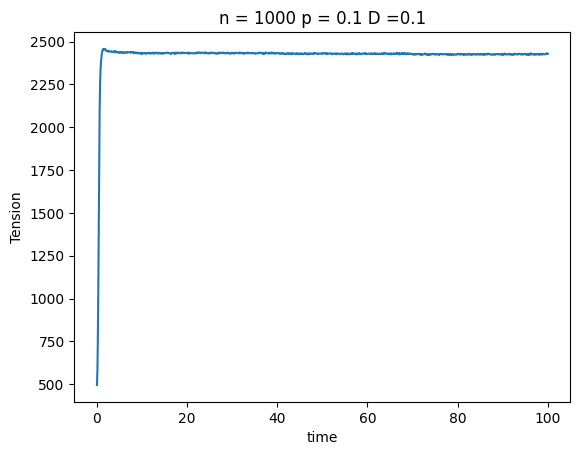

1000 0.1 0.25


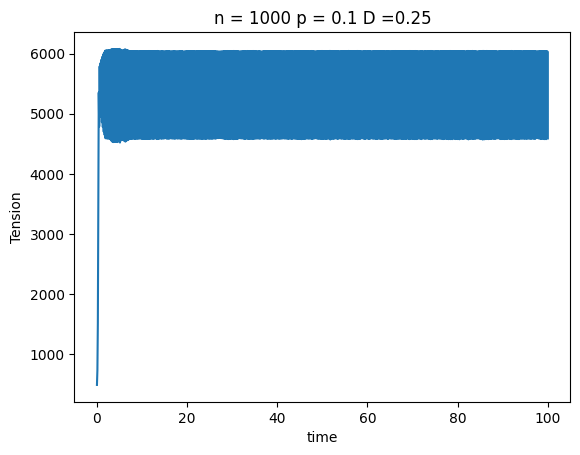

1000 0.1 0.5


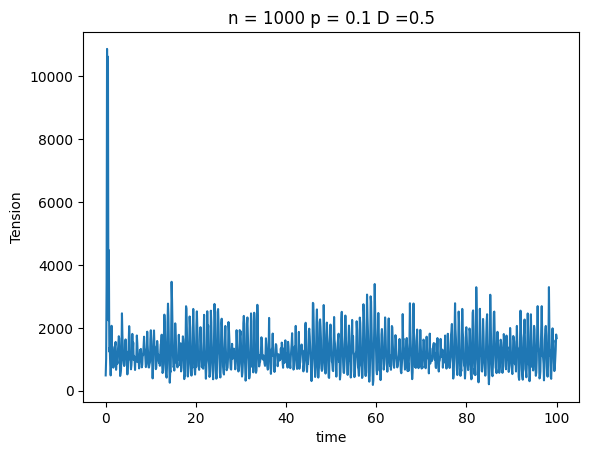

1000 0.1 0.75


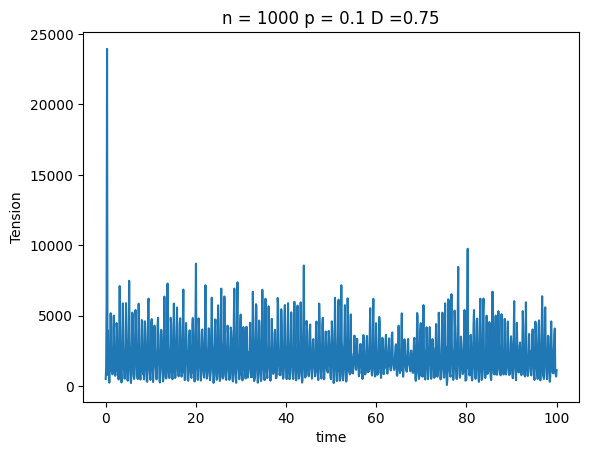

1000 0.1 0.9


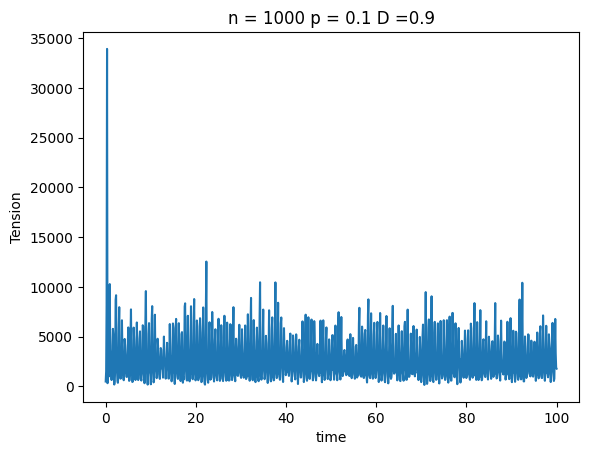

1000 0.5 0.1


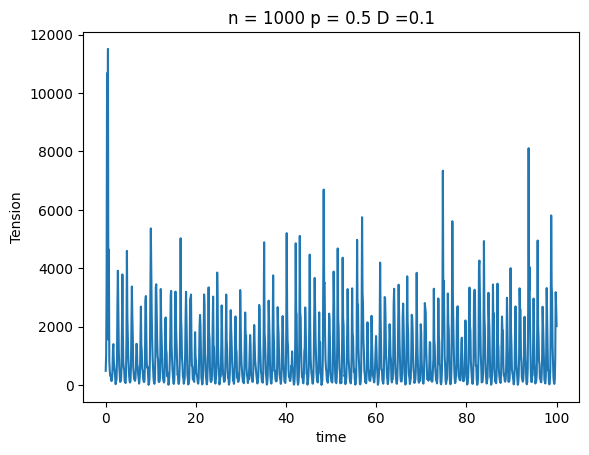

1000 0.5 0.25


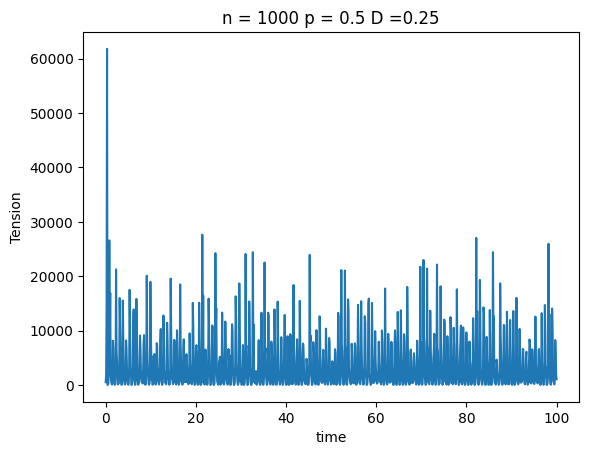

1000 0.5 0.5


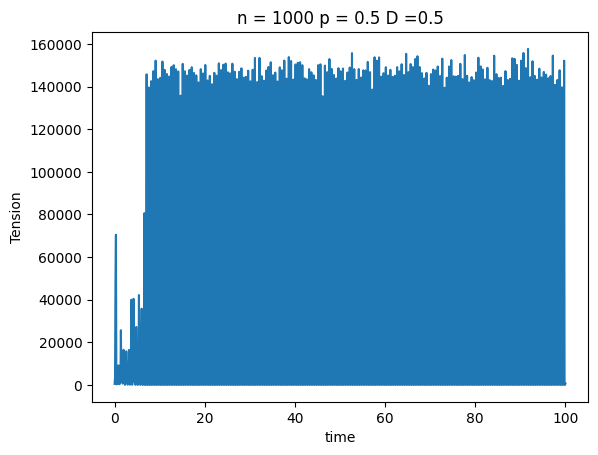

1000 0.5 0.75


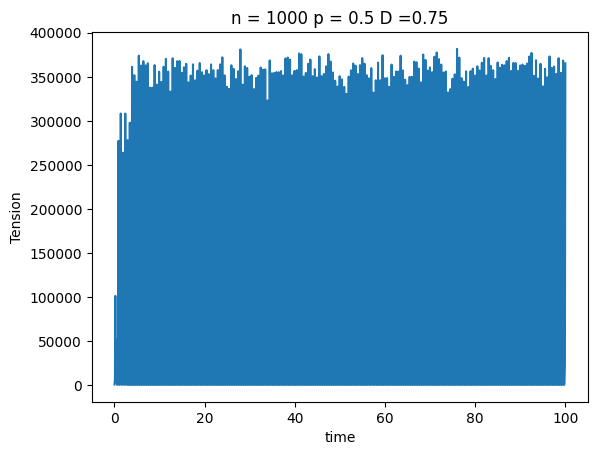

1000 0.5 0.9


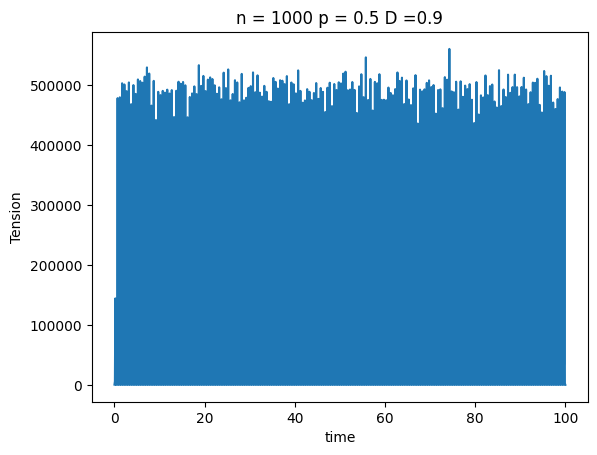

1000 0.75 0.1


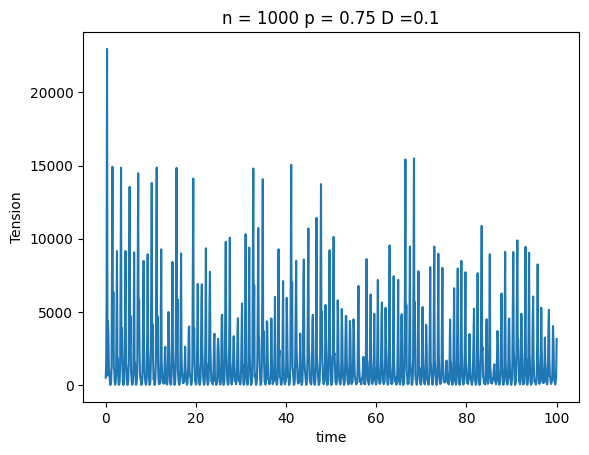

1000 0.75 0.25


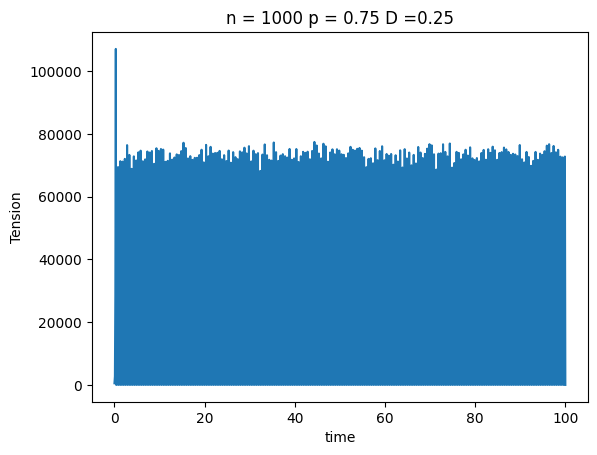

1000 0.75 0.5


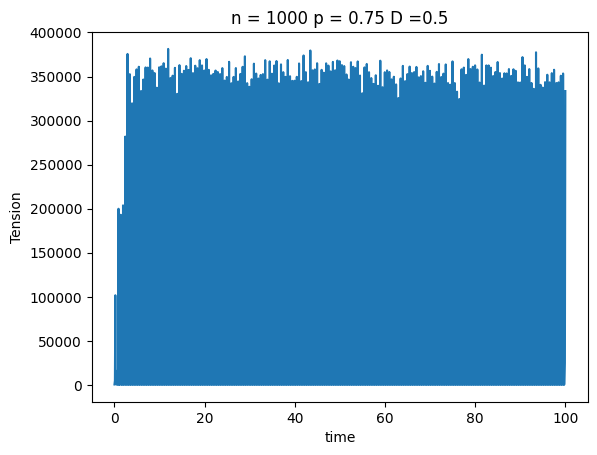

1000 0.75 0.75


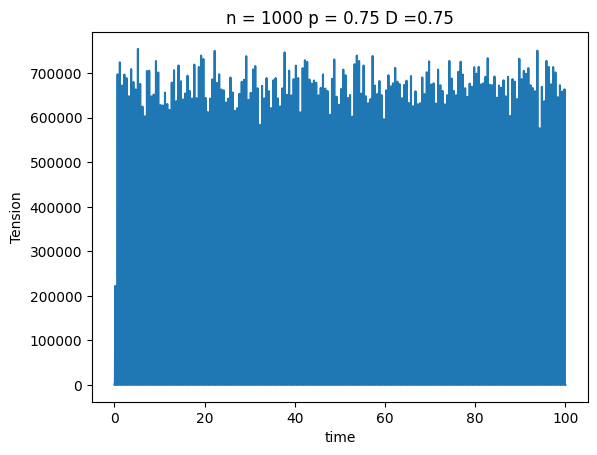

1000 0.75 0.9


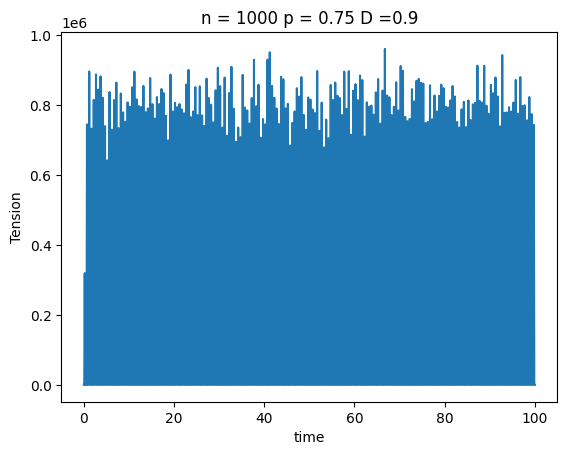

1000 0.9 0.1


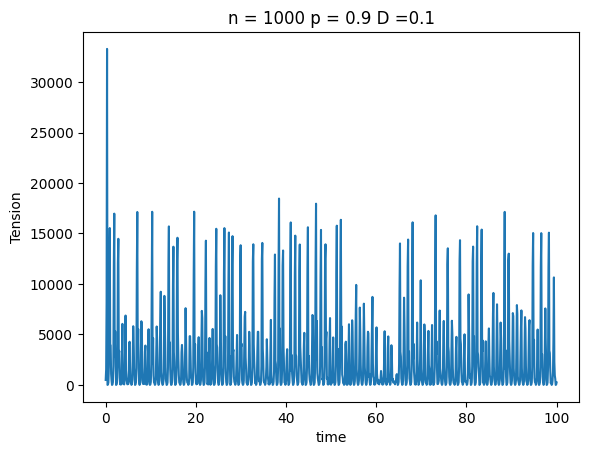

1000 0.9 0.25


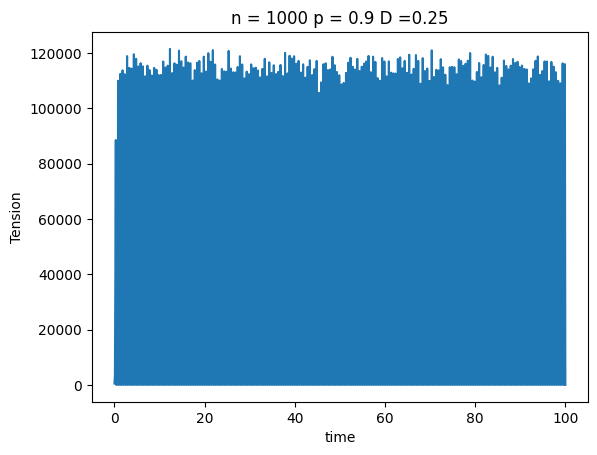

1000 0.9 0.5


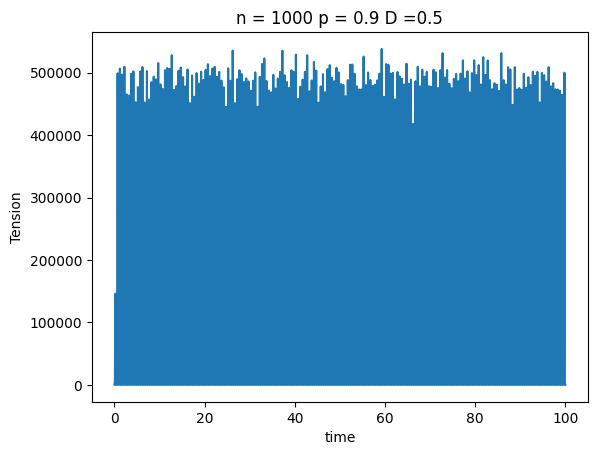

1000 0.9 0.75


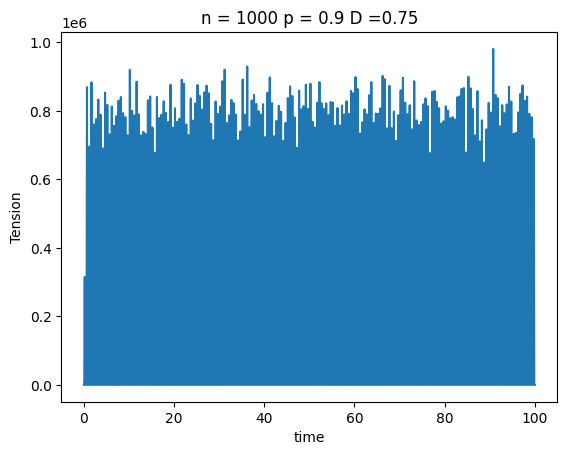

1000 0.9 0.9


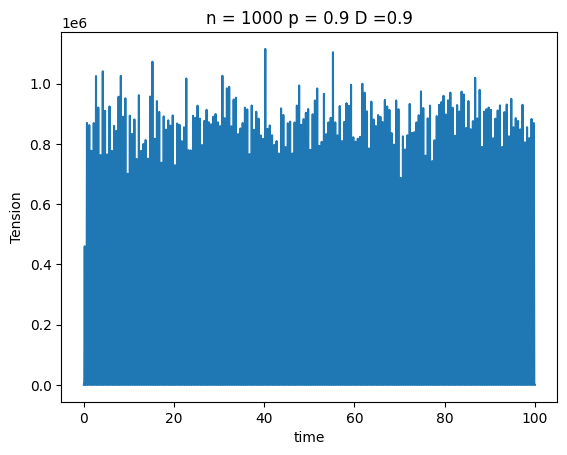

In [258]:
for s in sizes:
    for p in p_lst:
        for d in Diff:
            
            print(s,p,d)
            G2 = nx.erdos_renyi_graph(s,p)
            ADJ = nx.to_numpy_array(G2)
            Netwk = DynaNet(adj_mtx = ADJ)

            D = np.array([d for i in Netwk.vert])

            f0 = np.random.uniform(0,2, size = s)

            f0 = np.array(np.random.rand(ADJ.shape[0]))
            t0 = 0
            tf = 100
            nt = 1000
            def DE_for_graph_withRf0(Glag, Ggrad, f, t):
                return DE(Glag, Ggrad, f, D) + np.random.normal(0, 1, size = len(f0))
            t = np.linspace(t0, tf, nt)

            Netwk.dynamic_euler(DE_for_graph_withRf0, f0, t0, tf, nt)
            
            # with open(str(s) + '_'+ str(p) + '_' + str(d) + 'Network.pickle', 'wb') as handle:
            #     pickle.dump(Netwk, handle, protocol=pickle.HIGHEST_PROTOCOL)

            plt.plot(t, Netwk.dynamic.sum(axis =0))
            plt.xlabel('time')
            plt.ylabel('Tension')
            plt.title('n = ' + str(s) +' p = ' + str(p) + ' D ='+str(d))
            # plt.savefig('images\ER100\\'+str(s)+'p'+str(p)+'D'+str(d)+'avg.png')
            plt.show()

In [21]:
for s in sizes:
    for p in p_lst:
        for d in Diff:
            
            print(s,p,d)
            G2 = nx.erdos_renyi_graph(s,p)
            ADJ = nx.to_numpy_array(G2)
            Netwk = DynaNet(adj_mtx = ADJ)

            D = np.array([d for i in Netwk.vert])

            f0 = np.random.uniform(0,2, size = s)

            f0 = np.array(np.random.rand(ADJ.shape[0]))
            t0 = 0
            tf = 100
            nt = 1000
            def DE_for_graph_withRf0(Glag, Ggrad, f, t):
                return DE(Glag, Ggrad, f, D) + np.random.normal(0, 1, size = len(f0))
            t = np.linspace(t0, tf, nt)

            Netwk.dynamic_euler(DE_for_graph_withRf0, f0, t0, tf, nt)
            
            # with open(str(s) + '_'+ str(p) + '_' + str(d) + 'Network.pickle', 'wb') as handle:
            #     pickle.dump(Netwk, handle, protocol=pickle.HIGHEST_PROTOCOL)

            plt.plot(t, np.average(Netwk.dynamic, axis =0))
            plt.xlabel('time')
            plt.ylabel('Average Tension')
            plt.title('n = ' + str(s) +' p = ' + str(p) + ' D ='+str(d))
            plt.savefig('images\AVGComp\\'+str(s)+'p'+str(p)+'D'+str(d)+'avg.png')
            plt.show()

NameError: name 'sizes' is not defined

C:\Users\yassin\AppData\Local\Temp\ipykernel_19544\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


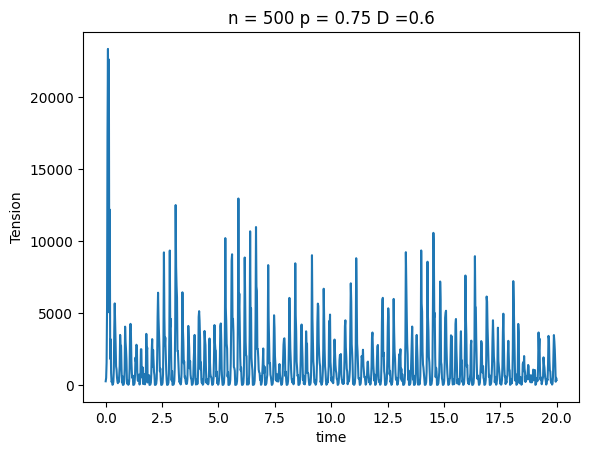

In [75]:
s = 500
p = 0.75
d = 0.6
G2 = nx.erdos_renyi_graph(s,p)
ADJ = nx.to_numpy_array(G2)
Netwk = DynaNet(adj_mtx = ADJ)

D = np.array([d for i in Netwk.vert])

f0 = np.random.uniform(0,2, size = s)

f0 = np.array(np.random.rand(ADJ.shape[0]))
t0 = 0
tf = 20
nt = 1000
def DE_for_graph_withRf0(Glag, Ggrad, f, t):
    return DE(Glag, Ggrad, f, D) + np.random.normal(0, 1, size = len(f0))
t = np.linspace(t0, tf, nt)

Netwk.dynamic_euler(DE_for_graph_withRf0, f0, t0, tf, nt)

# with open(str(s) + '_'+ str(p) + '_' + str(d) + 'Network.pickle', 'wb') as handle:
#     pickle.dump(Netwk, handle, protocol=pickle.HIGHEST_PROTOCOL)

plt.plot(t, Netwk.dynamic.sum(axis =0))
plt.xlabel('time')
plt.ylabel('Tension')
plt.title('n = ' + str(s) +' p = ' + str(p) + ' D ='+str(d))
plt.show()

In [84]:
place = np.argmax(Netwk.dynamic, axis = 1) 
time_mac = np.zeros([500,1000])
for i in range(0, 500):
    time_mac[i, place[i]] = 100
place

array([493, 300,  43, 642, 580, 395, 495, 325, 690, 825, 320, 924, 914,
       914, 702, 616,  86, 446, 669, 230, 804, 567, 858, 103, 518, 645,
       433, 883, 325, 980, 744, 280, 475, 308, 311, 955, 832, 982, 398,
       373, 699, 679, 331, 521, 521, 373, 868, 983, 668, 981, 409, 107,
       614, 850, 732, 315, 360, 754, 197, 308, 321, 397, 699, 497,  47,
       742,  19, 129, 268, 603, 712, 810, 280,  54, 197, 349, 133, 847,
       511, 546, 312, 809, 407, 857, 183, 641, 206, 433,   9, 209, 348,
       531, 871, 961, 972, 244, 776, 243, 322, 838, 893,  82, 993, 407,
       994, 214, 601, 789, 114,   5, 103, 906, 135, 475, 699, 688, 121,
       475, 789,  57, 383, 457, 861, 470, 246, 308, 627,  32, 573, 881,
       729, 909, 915, 320, 399, 678,  55, 844, 982, 797, 895, 703,   3,
       754,  46, 801, 347, 844, 680, 871, 767, 265, 187, 914, 519, 581,
       206, 487, 115,  79, 444, 483,  35, 103, 869, 879, 992, 767,  32,
       701, 764, 301,  90, 616, 308, 444, 155, 752, 374, 574, 42

In [105]:
# [[x,list(place).count(x)] for x in set(place)]

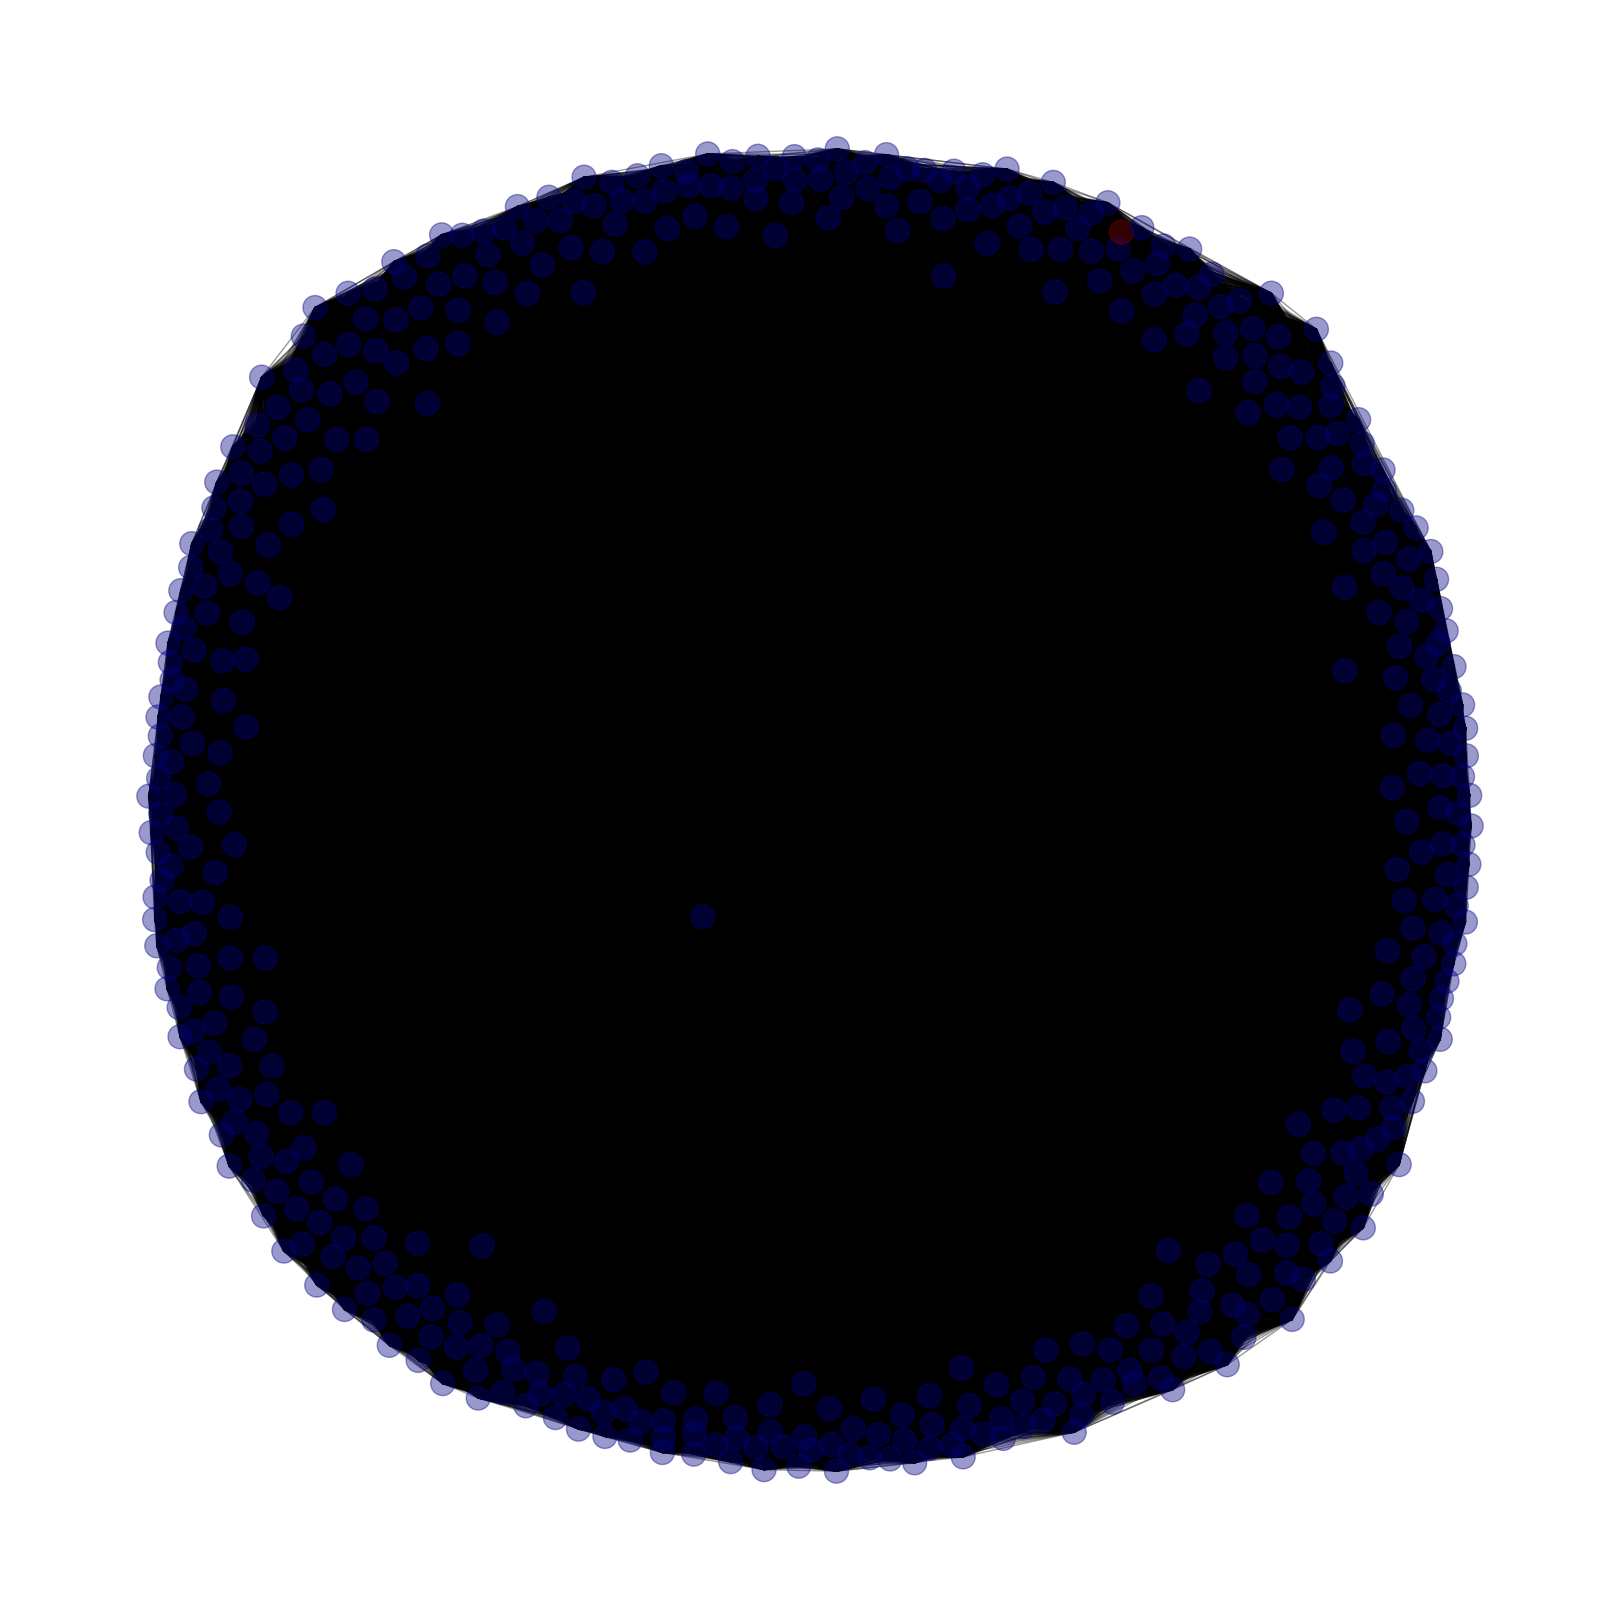

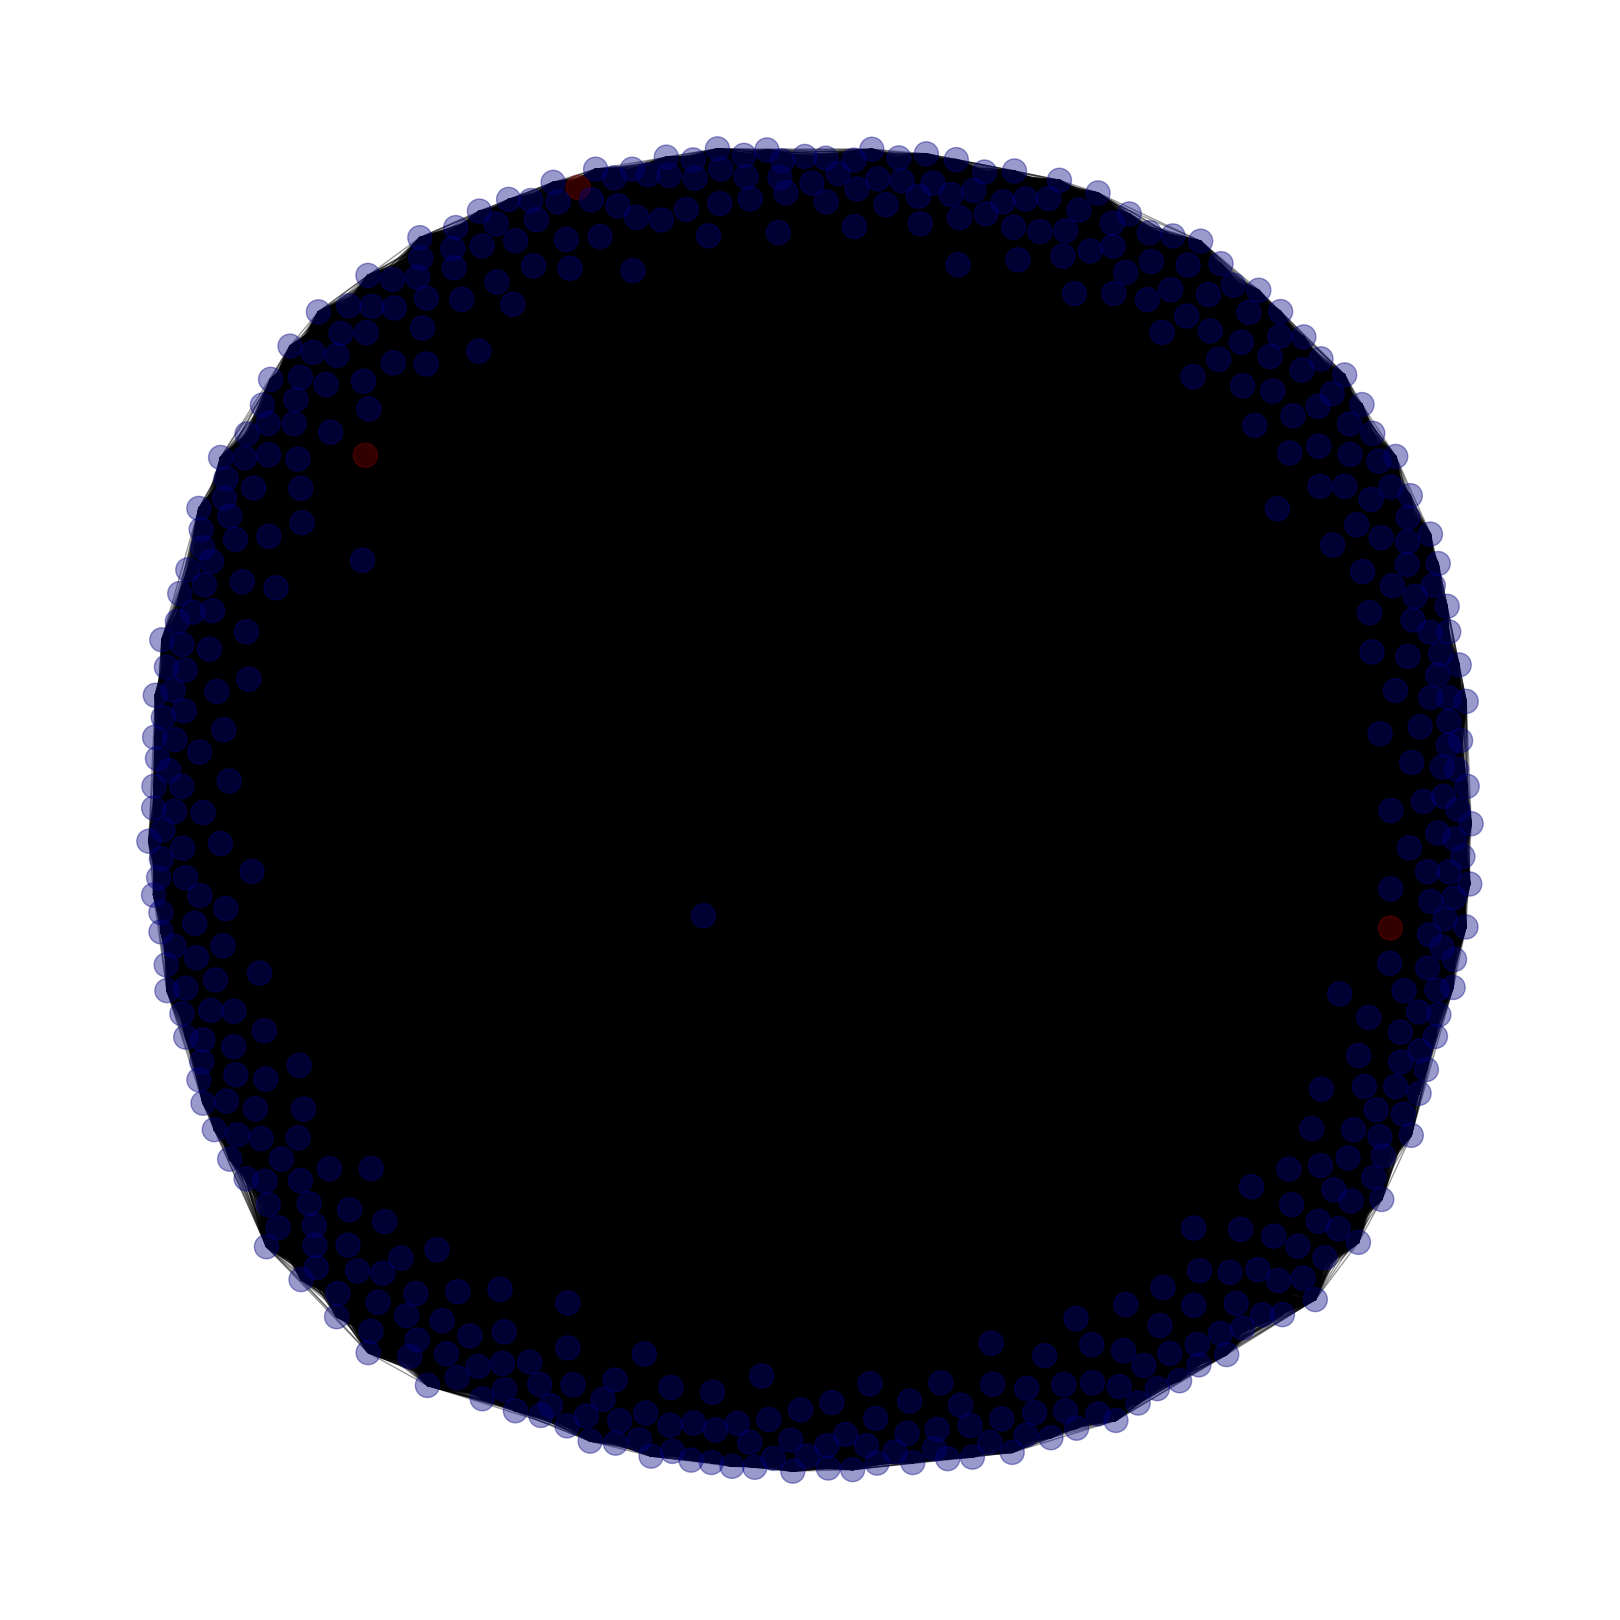

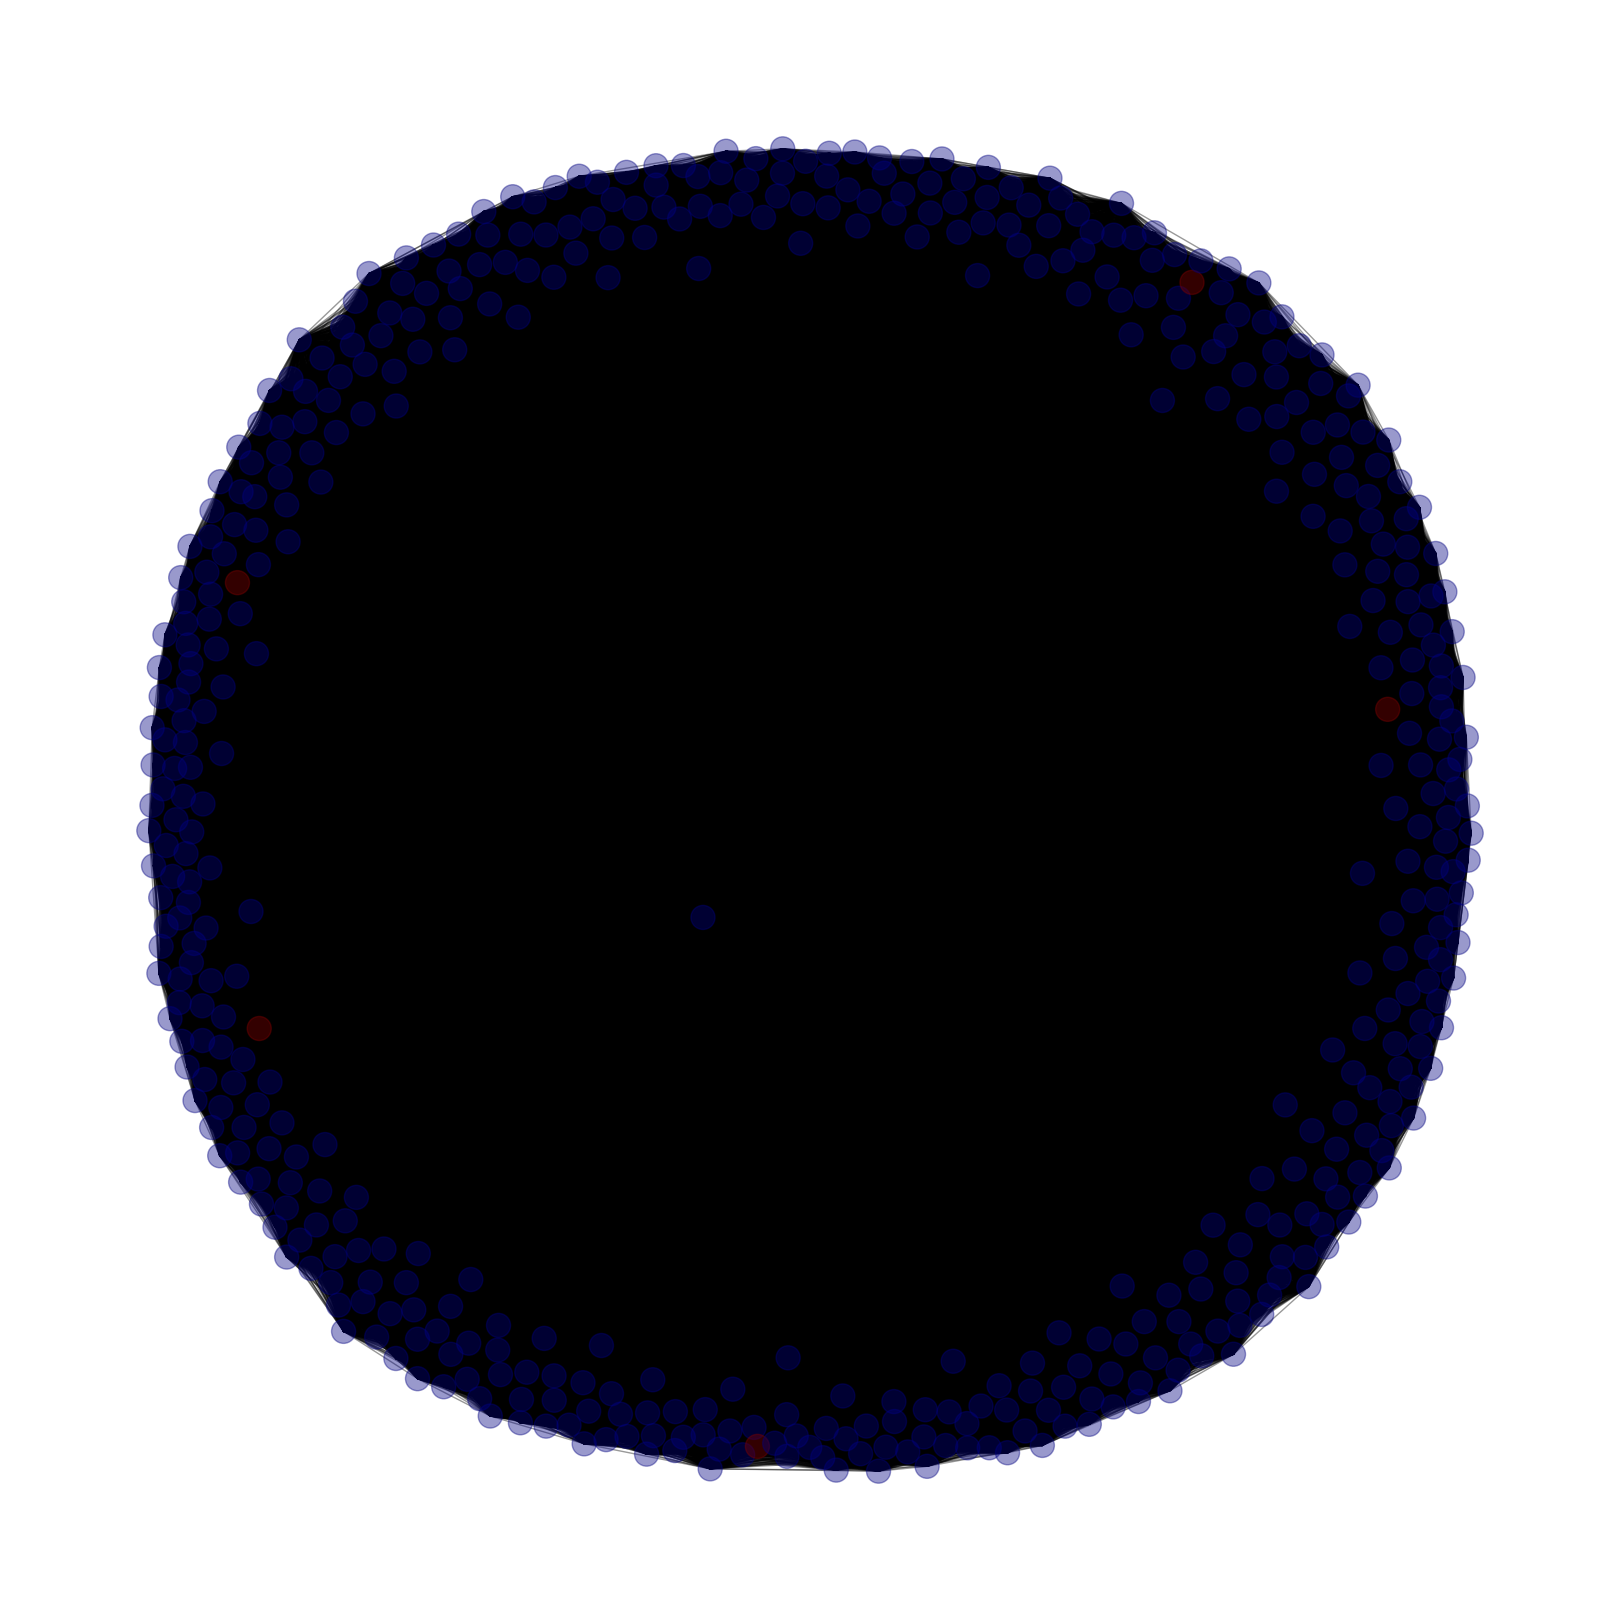

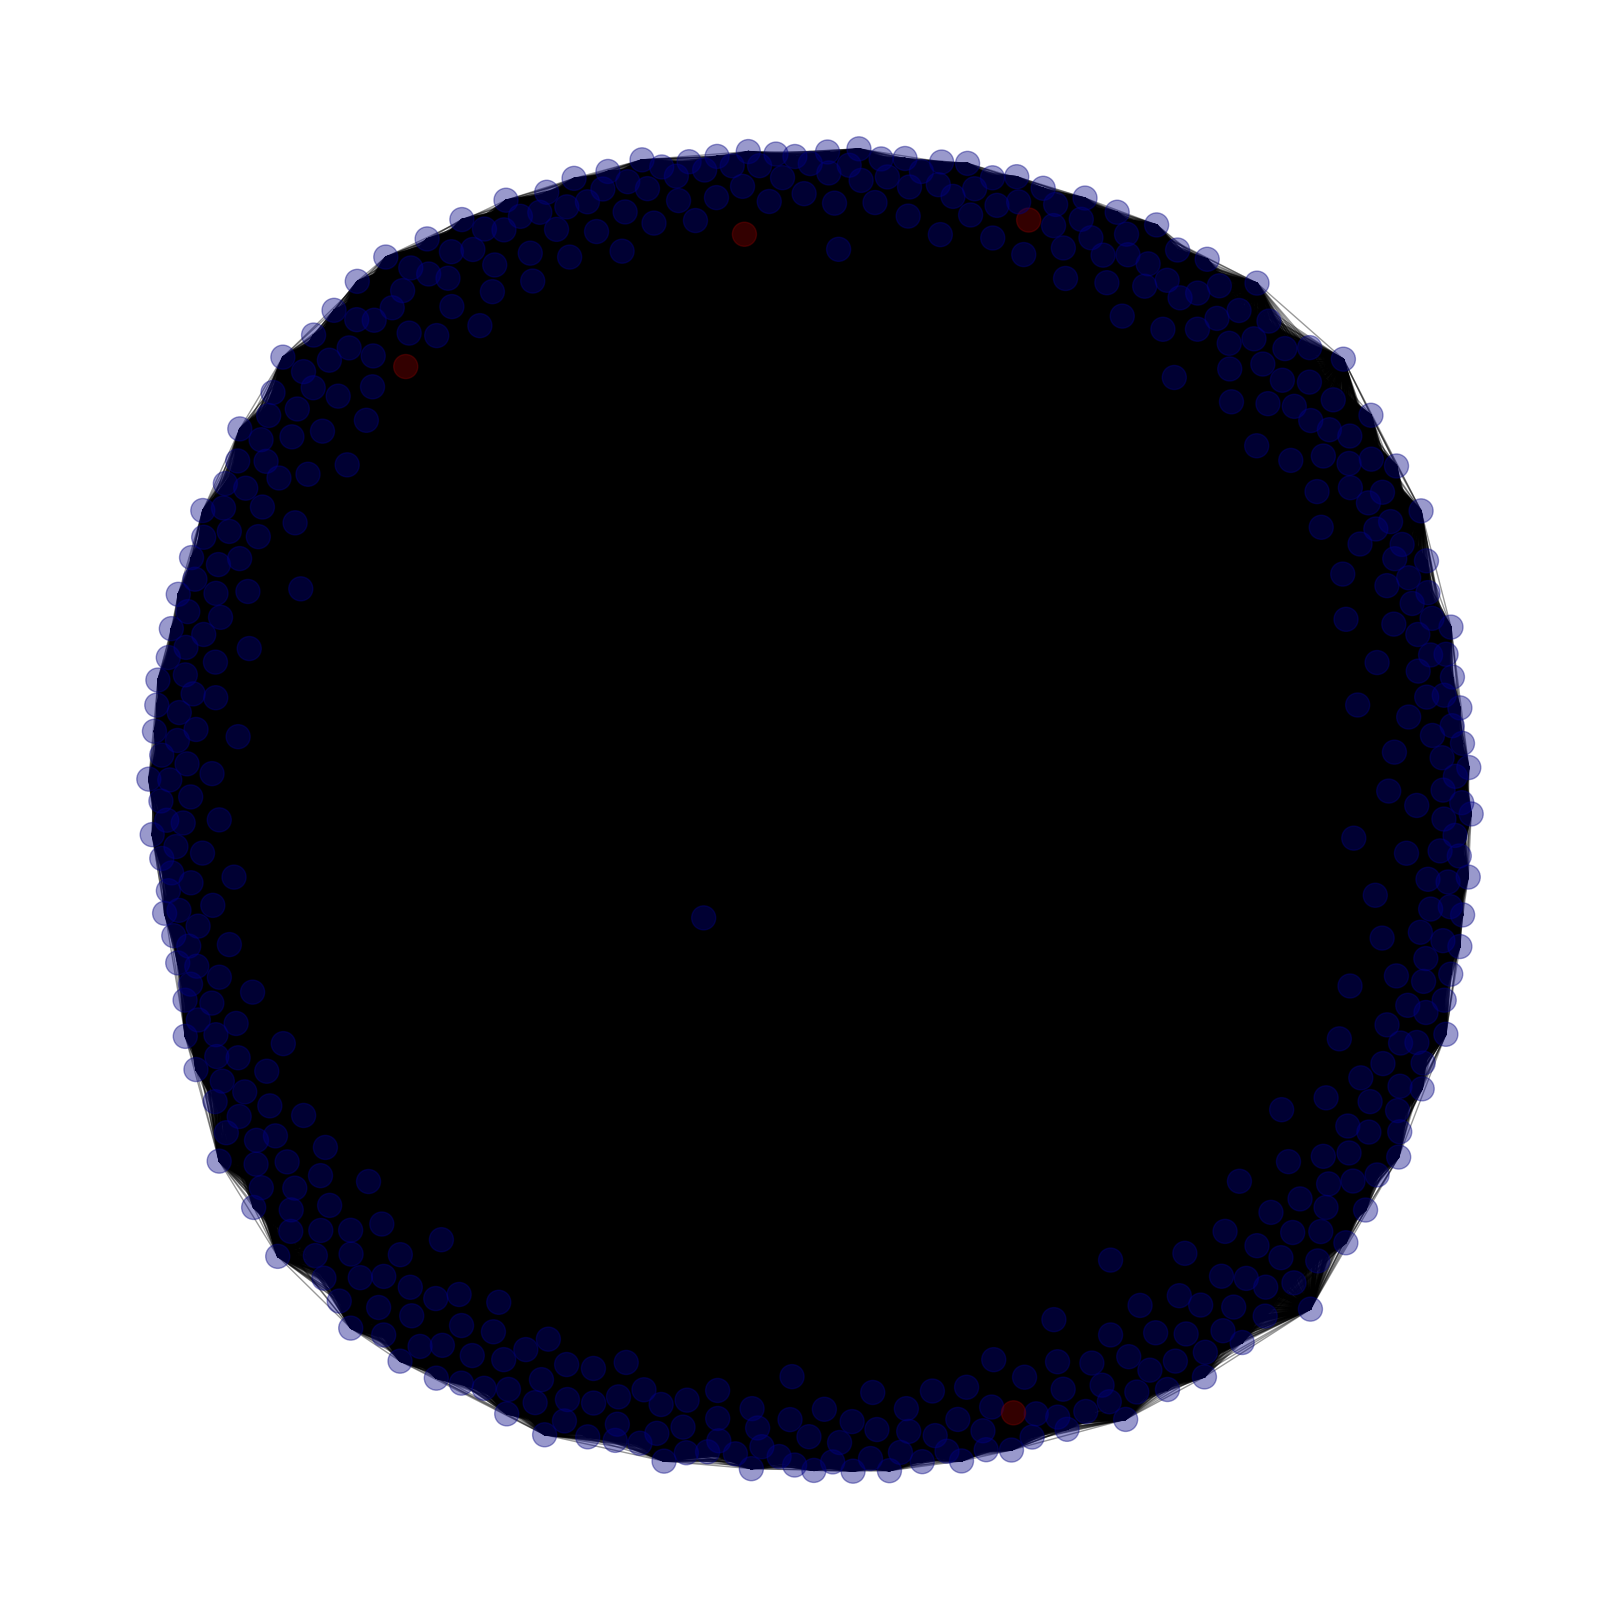

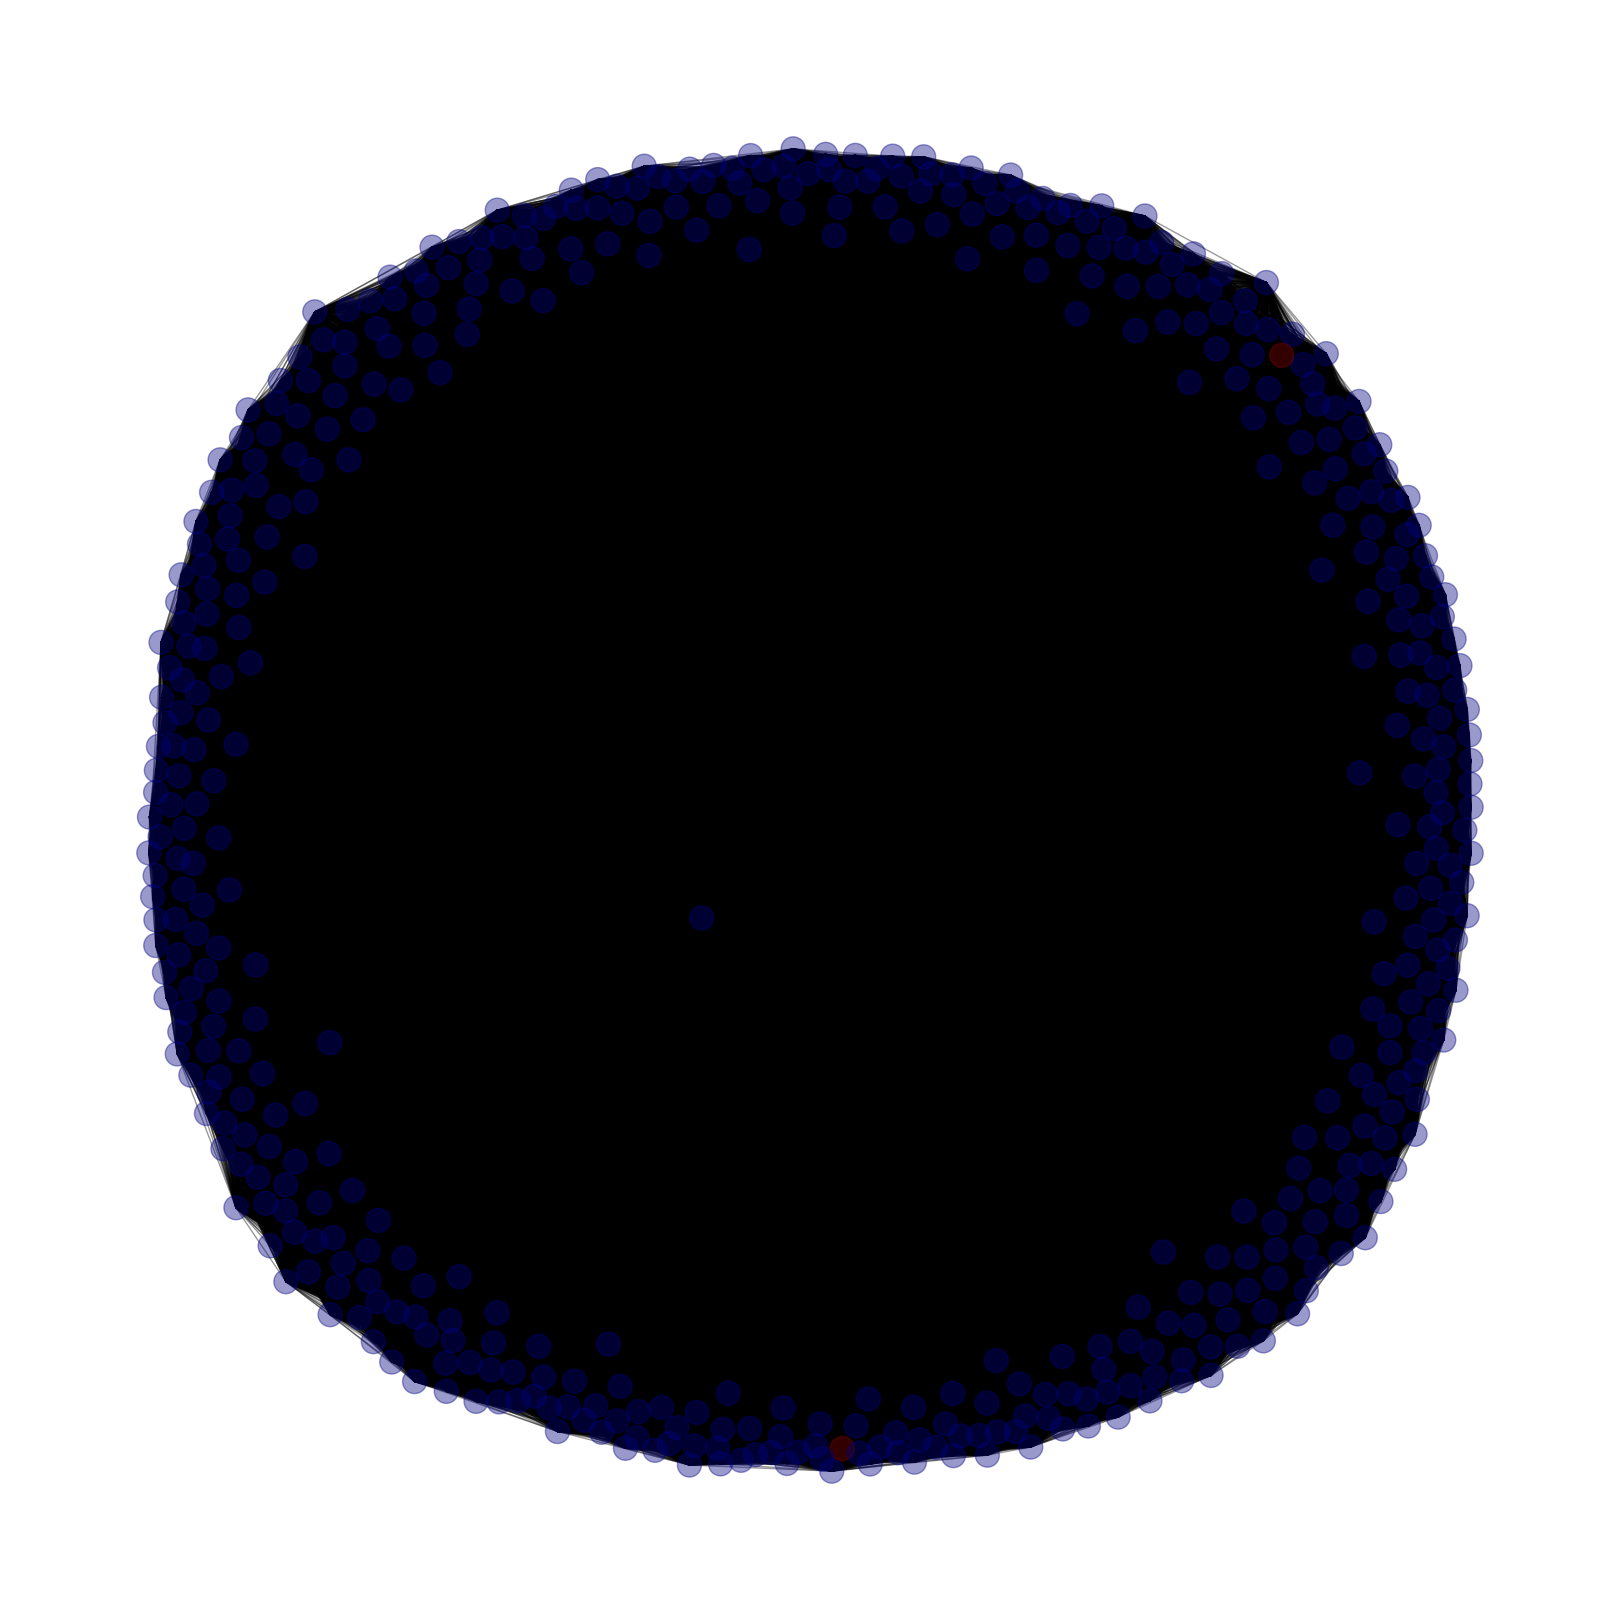

In [94]:
# (other code above this line)
#
# for i in [0,100,200,300,400,500,600,700,800,900]:
for i in [1,19,79,170,221]:
    plt.figure(figsize=(16,16))

    # node colors

    values = time_mac[:,i]


    # Nodes layout/ position
    fixed_positions = {0:(0,0)}
    fixed_nodes = fixed_positions.keys()
    pos = nx.spring_layout(G2,pos=fixed_positions, fixed = fixed_nodes, k=15)
    # pos = nx.circular_layout(G, scale=2)

    node_sizes = [1000] + [200]*283

    nx.draw(G2, cmap=plt.get_cmap('jet'), node_color=values,
            alpha=0.4, 
                   pos=pos)


In [ ]:
# with open('filename.pickle', 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print(a == b)

# Different degrees:

In [29]:
s_lst = [100,200,300,400,500]
sum_lst = []
tim_lst = []
for s in s_lst:
    vert = s
    deg_seq = [i for i in range(0, s)]                     
    deg_seq        
    d = 0.6
    dyna = []
    ittr_num = 5000
    for g in range(0, ittr_num):
        print(g, end = '\r')
        G2 = nx.expected_degree_graph(deg_seq, selfloops=False)
        ADJ = nx.to_numpy_array(G2)
        Netwk = DynaNet(adj_mtx = ADJ)

        D = np.array([d for i in Netwk.vert])

        f0 = np.random.uniform(0,2, size = vert)
        v = 0
        f0 = np.array(np.random.rand(ADJ.shape[0]))
        t0 = 0
        tf = 100
        nt = 1000
        def DE_for_graph_withRf0(Glag, Ggrad, f, t):
            return DE(Glag, Ggrad, f, D) + np.random.normal(0, 1, size = len(f0))
        t = np.linspace(t0, tf, nt)

        Netwk.dynamic_euler(DE_for_graph_withRf0, f0, t0, tf, nt)

        dyna += [Netwk.dynamic]
    
    Mtx_sum = np.max(dyna[0], axis = 1)
    for i in range(1, ittr_num):
        Mtx_sum = Mtx_sum + np.max(dyna[i], axis = 1)
    sum_lst += [Mtx_sum]
    
    max_time = np.argmax(dyna[0], axis = 1)+1
    for i in range(1, ittr_num):
        max_time = max_time + (np.argmax(dyna[i], axis = 1) +1)
    tim_lst += [max_time]
    
# with open(str(s) + '_'+ str(p) + '_' + str(d) + 'Network.pickle', 'wb') as handle:
#     pickle.dump(Netwk, handle, protocol=pickle.HIGHEST_PROTOCOL)

# plt.plot(t, Netwk.dynamic.sum(axis =0))
# plt.xlabel('time')
# plt.ylabel('Tension')
# plt.show()

C:\Users\yassin\AppData\Local\Temp\ipykernel_3268\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


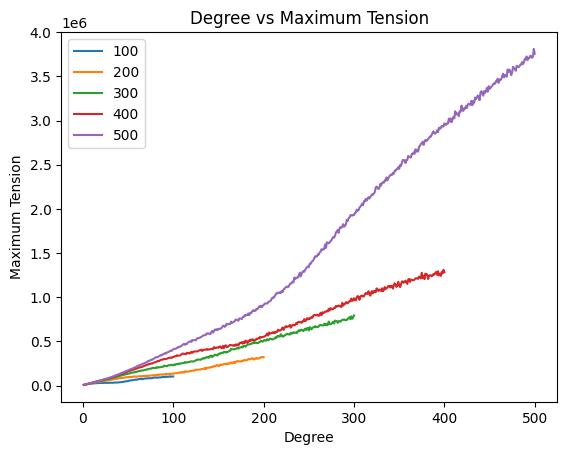

In [31]:
# Mtx_sum = np.max(dyna[0], axis = 1)

# for i in range(1, ittr_num):
#     Mtx_sum = Mtx_sum + np.max(dyna[i], axis = 1)
for i in range(0, len(s_lst)):
# Mtx_sum = Mtx_sum/ittr_num
# print(len(Mtx_sum))
    
    plt.plot([t+1 for t in range(0, s_lst[i])], sum_lst[i], label = str(s_lst[i]))
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Maximum Tension')
plt.title('Degree vs Maximum Tension')
plt.show()

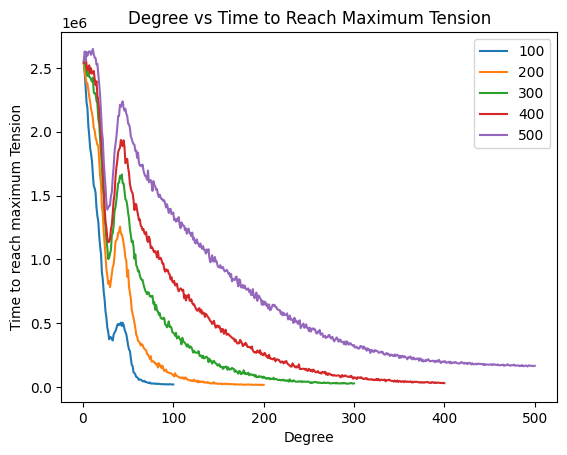

In [32]:
# max_time = np.argmax(dyna[0], axis = 1)+1

# for i in range(1, ittr_num):
#     max_time = max_time + (np.argmax(dyna[i], axis = 1) +1)

# max_time = max_time/ittr_num
# print(len(max_time))

# plt.plot([i+1 for i in range(0, s)], max_time)
# Mtx_sum = np.max(dyna[0], axis = 1)

# for i in range(1, ittr_num):
#     Mtx_sum = Mtx_sum + np.max(dyna[i], axis = 1)
for i in range(0, len(s_lst)):
# Mtx_sum = Mtx_sum/ittr_num
# print(len(Mtx_sum))
    
    plt.plot([t+1 for t in range(0, s_lst[i])], tim_lst[i], label = str(s_lst[i]))
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Time to reach maximum Tension')
plt.title('Degree vs Time to Reach Maximum Tension')
plt.show()

# One Popular Node

In [12]:
s = 100
print([i for i in range(int(0.9*s), s+1) ])
len([0 for _ in range(1,s)])

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


99

In [20]:
s_lst = [100,200,300,400,500]
sum_lst_pop = []
tim_lst_pop = []
sum_lst_com = []
tim_lst_com = []
for s in s_lst:
    print('POPPPPPP ', s)
    vert = s                        
    d = 0.6
    ittr_num = 5000
    max_time_pop_lst = []
    max_pop_lst = []
    max_time_com_lst = []
    max_com_lst = []
    for g in range(0, ittr_num):
        print(g, end = '\r')
        deg_seq = [random.choice([i for i in range(int(0.9*s), s+1) ])] + [random.choice([i for i in range(0, int(0.2*s))]) for _ in range(1,s)] 
        G2 = nx.expected_degree_graph(deg_seq, selfloops=False)
        ADJ = nx.to_numpy_array(G2)
        Netwk = DynaNet(adj_mtx = ADJ)

        D = np.array([d for i in Netwk.vert])

        f0 = np.random.uniform(0,2, size = vert)
        v = 0
        f0 = np.array(np.random.rand(ADJ.shape[0]))
        t0 = 0
        tf = 100
        nt = 1000
        def DE_for_graph_withRf0(Glag, Ggrad, f, t):
            return DE(Glag, Ggrad, f, D) + np.random.normal(0, 1, size = len(f0))
        t = np.linspace(t0, tf, nt)

        Netwk.dynamic_euler(DE_for_graph_withRf0, f0, t0, tf, nt)
        dyna = Netwk.dynamic
        max_all = np.max(dyna, axis = 1)
        max_pop = max_all[0]
        max_comonner = np.sum(max_all[1:])/len(max_all[1:])
        max_time_all = np.argmax(dyna, axis = 1) +1
        max_time_pop = max_time_all[0]
        max_time_comonner = np.sum(max_time_all[1:])/len(max_time_all[1:])
        
        max_time_pop_lst += [max_time_pop]
        max_pop_lst = [max_pop]
        max_time_com_lst += [max_time_comonner]
        max_com_lst = [max_comonner]
    
    sum_lst_pop += [sum(max_pop_lst)/len(max_pop_lst)]
    tim_lst_pop += [sum(max_time_pop_lst)/len(max_time_pop_lst)]
    sum_lst_com += [sum(max_com_lst)/len(max_com_lst)]
    tim_lst_com += [sum(max_time_com_lst)/len(max_time_com_lst)]
# with open(str(s) + '_'+ str(p) + '_' + str(d) + 'Network.pickle', 'wb') as handle:
#     pickle.dump(Netwk, handle, protocol=pickle.HIGHEST_PROTOCOL)

# plt.plot(t, Netwk.dynamic.sum(axis =0))
# plt.xlabel('time')
# plt.ylabel('Tension')
# plt.show()

POPPPPPP  100


C:\Users\yassin\AppData\Local\Temp\ipykernel_19544\3809078228.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_mtx == []:


POPPPPPP  200  999
POPPPPPP  300  999
POPPPPPP  400  999
POPPPPPP  500  999


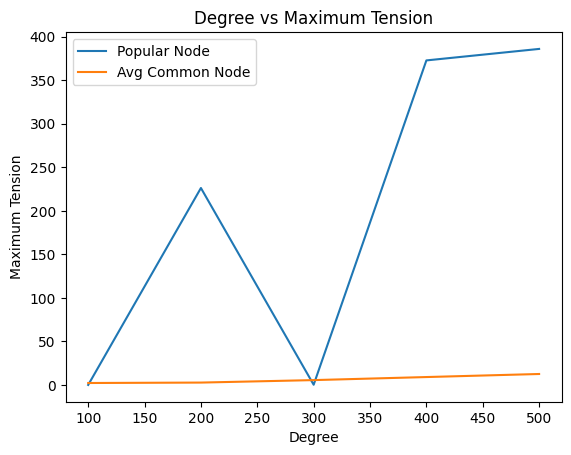

In [28]:
plt.plot(s_lst, sum_lst_pop, label = 'Popular Node')
plt.plot(s_lst, sum_lst_com, label = 'Avg Common Node')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Maximum Tension')
plt.title('Degree vs Maximum Tension')
plt.show()

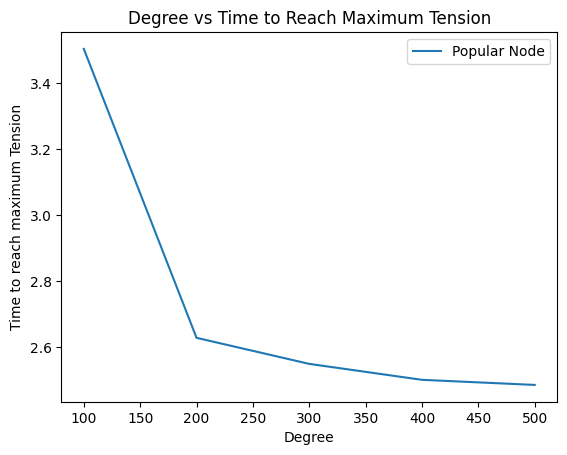

In [35]:
plt.plot(s_lst, tim_lst_pop, label = 'Popular Node')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Time to reach maximum Tension')
plt.title('Degree vs Time to Reach Maximum Tension')
plt.show()

In [33]:
tim_lst_com

[182.5784000000009,
 118.36379195979909,
 109.65170635451523,
 111.1824807017542,
 104.98558597194388]

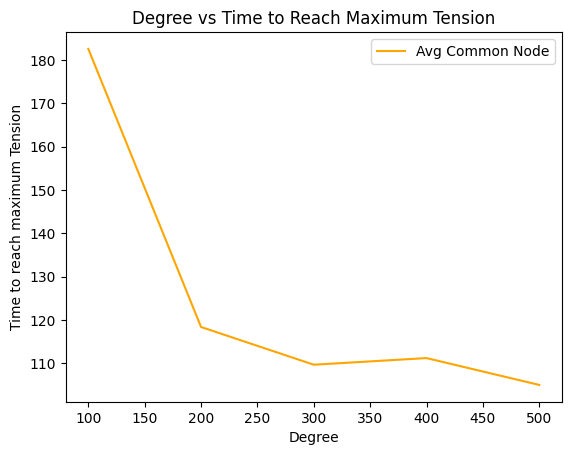

In [34]:
plt.plot(s_lst, tim_lst_com, label = 'Avg Common Node', color = 'orange')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Time to reach maximum Tension')
plt.title('Degree vs Time to Reach Maximum Tension')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,5))
sum_labels = ['Pop Node Max', 'Low Deg Avg']

axes[0].barh(y_pos, training_times, align='center')
axes[0].set_yticks(y_pos, labels=labels)
axes[0].invert_yaxis()  # labels read top-to-bottom
axes[0].set_xlabel('time in sec')
axes[0].set_title('Training Runtime')

In [97]:
np.argmax(np.array([[1,2],
               [5,3]]), axis = 1 ) +1

array([2, 1], dtype=int64)

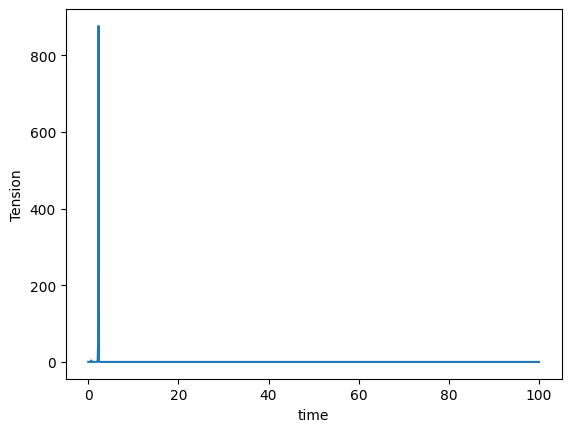

In [79]:
# plt.plot(t, Netwk.dynamic[0,:])
plt.plot(t, Netwk.dynamic[499,:])
# plt.plot(t, Netwk.dynamic[499,:])
# plt.plot(t, Netwk.dynamic[499,:])
plt.xlabel('time')
plt.ylabel('Tension')
plt.show()

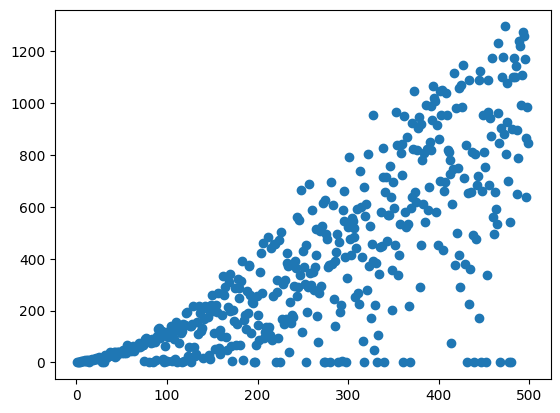

In [82]:
peak = []
for i in range(0, 499):
    peak += [max(Netwk.dynamic[i,:])]
    
plt.scatter([i+1 for i in range(0, 499)], peak)

In [65]:
len(A)

499

# Community Model:

In [36]:
def listdistance(C, l, d):

    if len(l) == 2:
        C[l[0], l[1]] = d
        C[l[1], l[0]] = d
    else:
        l1 = l[0:int(len(l)/2)]
        l2 = l[int(len(l)/2):len(l)]
        for a in l1:
            for b in l2:
                C[a, b] = d
                C[b, a] = d
        listdistance(C, l1, d-1)
        listdistance(C, l2, d-1)

In [41]:
class ComDynaNet():
    def __init__(self, N = 100, c = 1):
        '''
        com: Number of communities,
        N: total number of of agents.
        '''
        self.c = c
        self.N = N
        self.n = int(N/c)
        
        ex = 0
        while ex < 32:
            if c == 2**ex:
                dmax = ex
                break
            ex += 1
        
        
        self.community_dist = np.zeros([c,c])
        grp_lst = [i for i in range(0, c)]
        d = dmax
        listdistance(self.community_dist , grp_lst, d)
    
    
        self.adj_mtx = np.ones(self.n) - np.eye(self.n)
    
        self.vert = [i for i in range(0, self.adj_mtx.shape[0])]
        self.edge = []
        for i in self.vert:
            for j in range(i, self.adj_mtx.shape[1]):
                if self.adj_mtx[i,j] == 1:
                    self.edge += [[i,j]]

    def generate_incidence(self):
        
        self.incidence_mtx = np.zeros([len(self.vert), len(self.edge)])
        for e in range(0, len(self.edge)):
            self.incidence_mtx[ min(self.edge[e]), e] = 1
            self.incidence_mtx[ max(self.edge[e]), e] = -1

    def graph_gradient(self):
        '''
        returns adjacency like matrix that is the gradient of each vetice
        '''
        self.grad_mtx = np.zeros(self.adj_mtx.shape)
        
        for e in self.edge:
            self.grad_mtx[e[0], e[0]] += 1
            self.grad_mtx[e[0], e[1]] = -1
            self.grad_mtx[e[1], e[1]] += 1
            self.grad_mtx[e[1], e[0]] = -1
        
        
    
    def Simulation_euler(self, df, t0, tf, nt, lbd, init_value, p, D):
        
        
        self.generate_incidence()
        self.graph_gradient()
        K = self.incidence_mtx
        # print(K)
        
        Glag = np.dot(K, np.transpose(K))
        Ggrad = self.grad_mtx
        # print(Glag)
        
        
        t = np.linspace(t0, tf, nt)
        proba = (self.community_dist+1)**(-lbd)
        f0 = np.array([1 for _ in range(0,self.N)])
        patient_zero = random.choice([i for i in range(0, self.N)])
        
        f0[patient_zero] = init_value
        f = np.zeros([self.N, len(t)])
        f[:,0] = f0
        dt = (tf-t0)/nt
        inter = 0
        # print(patient_zero)
        for i in range(1, len(t)):
            # print('time step.... ', i, end = '\r')
            for comu in range(0,self.c):
                fcom = f[comu*self.n:(comu+1)*self.n,i-1]
                fcomp1 = fcom + dt*df(Glag, Ggrad, fcom,t[i-1])
                f[comu*self.n:(comu+1)*self.n, i] = np.maximum(np.zeros(len(fcomp1)),fcomp1)
            
            #### Diffusing tension to other groups:
            # 
            mov = random.choices([0,1]  , weights = (1-p, p))[0]                                          
            # print(mov)
            
            if mov == 1:
                # print('Doing diffusion')
                inter = inter + 1
                com_to_interact_1 = random.choices([i for i in range(0,self.c)])[0]     
                com_to_interact_2 = random.choices([i for i in range(0,self.c) if i != com_to_interact_1])[0]
                node_1 = random.choice([i for i in range(com_to_interact_1*self.n, (com_to_interact_1+1)*self.n)])
                node_2 = random.choice([i for i in range(com_to_interact_2*self.n, (com_to_interact_2+1)*self.n)])
                f[node_1, i] =  f[node_1, i] - D* f[node_1, i] + D* f[node_2, i]
                f[node_2, i] =  f[node_2, i] - D* f[node_2, i] + D* f[node_1, i]
                # print('interactions happening', f[patient_zero, i])
        self.dynamic = f

    

D 0.1 p 0.1
D 0.1 p 0.25
D 0.1 p 0.5
D 0.1 p 0.75
D 0.1 p 0.9


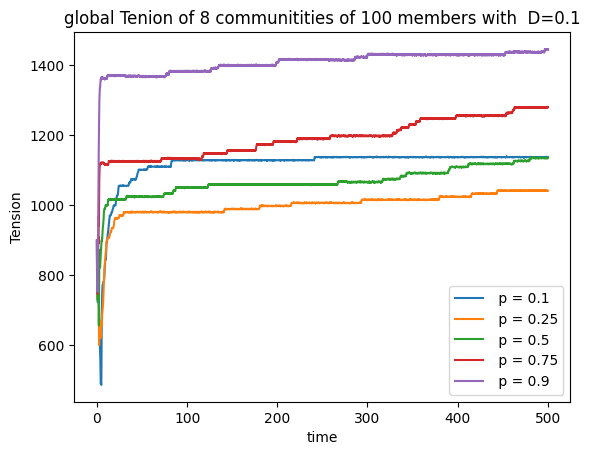

D 0.25 p 0.1
D 0.25 p 0.25
D 0.25 p 0.5
D 0.25 p 0.75
D 0.25 p 0.9


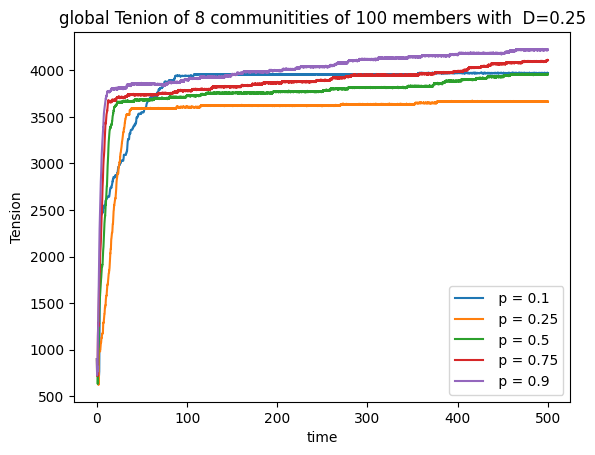

D 0.5 p 0.1
D 0.5 p 0.25
D 0.5 p 0.5
D 0.5 p 0.75
D 0.5 p 0.9


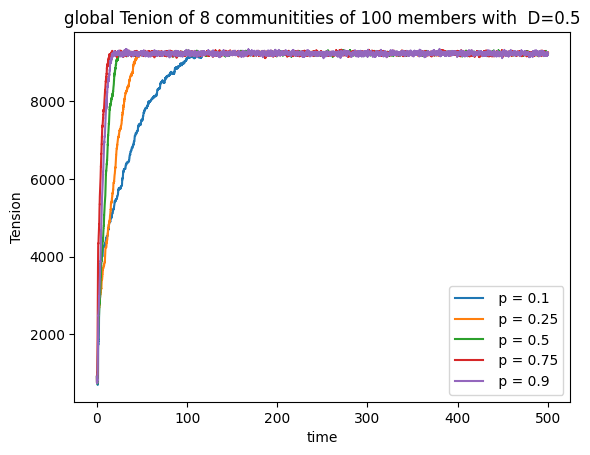

D 0.75 p 0.1
D 0.75 p 0.25
D 0.75 p 0.5
D 0.75 p 0.75
D 0.75 p 0.9


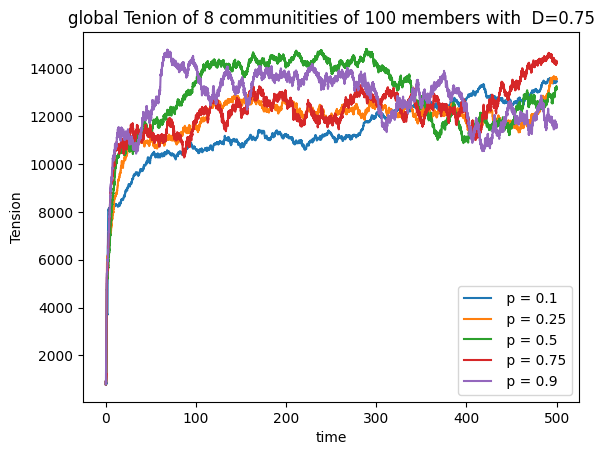

D 0.9 p 0.1
D 0.9 p 0.25
D 0.9 p 0.5
D 0.9 p 0.75
D 0.9 p 0.9


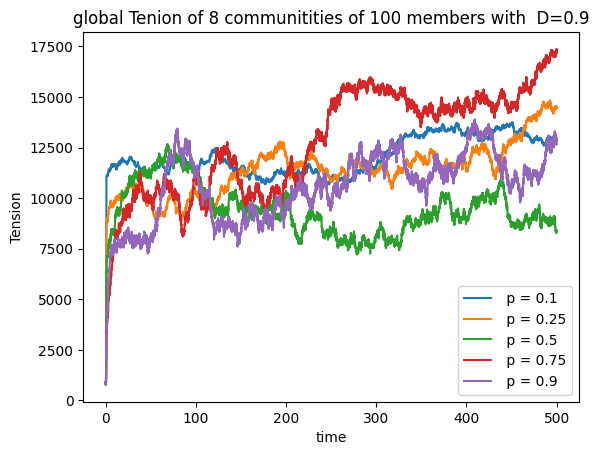

In [47]:
ComNet = ComDynaNet(100*8, 8)

D_lst = [0.1,0.25,0.5,0.75,0.9]
p_lst = [0.1,0.25,0.5,0.75,0.9]
for D in D_lst:
    for p in p_lst:
        print('D',D, 'p', p)
        t0 = 0
        tf = 500
        nt = 50000
        init_value = 100
        def DE(Glap, Ggrad, f, D):
            '''
            GLag: graph Laplacian
            Ggrad: graph gradient
            f: state 
            D: vector ofdiffusion coefficient.
            v: velocity the tension is moving by.
            '''
            Dxf = np.multiply(D, f)
            gradf = np.dot(Ggrad, f)
            df = np.dot(Glap, Dxf) + np.multiply(f, 1-f)

            return df
        def DE_for_graph_withRf0(Glag, Ggrad, f, t):
            return DE(Glag, Ggrad, f, D) #+ np.random.normal(0, 0.5, size = len(f))
        t = np.linspace(t0, tf, nt)
        lbd = 1
        ComNet.Simulation_euler(DE_for_graph_withRf0, t0, tf, nt, lbd, init_value, p, D)

        plt.plot(t, ComNet.dynamic.sum(axis =0), label =' p = '+str(p))
    plt.xlabel('time')
    plt.ylabel('Tension')
    plt.legend()
    plt.title('global Tenion of 8 communitities of 100 members with  D=' + str(D) )
    plt.savefig('images/hiear/D=' + str(D)+'.png')
    plt.show()


In [21]:
 # ComNet.dynamic[199,:]

In [46]:
Netwk.dynamic.sum(axis =0)[0]

NameError: name 'Netwk' is not defined

In [122]:
256*32

8192

# Communities against each other:

In [100]:
class ComDynaNet():
    def __init__(self, N = 100, c = 1):
        '''
        com: Number of communities,
        N: total number of of agents.
        '''
        self.c = c
        self.N = N
        self.n = int(N/c)
        
        ex = 0
        while ex < 32:
            if c == 2**ex:
                dmax = ex
                break
            ex += 1
        
        
        self.community_dist = np.zeros([c,c])
        grp_lst = [i for i in range(0, c)]
        d = dmax
        listdistance(self.community_dist , grp_lst, d)
    
    
        self.adj_mtx = np.ones(self.n) - np.eye(self.n)
    
        self.vert = [i for i in range(0, self.adj_mtx.shape[0])]
        self.edge = []
        for i in self.vert:
            for j in range(i, self.adj_mtx.shape[1]):
                if self.adj_mtx[i,j] == 1:
                    self.edge += [[i,j]]

    def generate_incidence(self):
        
        self.incidence_mtx = np.zeros([len(self.vert), len(self.edge)])
        for e in range(0, len(self.edge)):
            self.incidence_mtx[ min(self.edge[e]), e] = 1
            self.incidence_mtx[ max(self.edge[e]), e] = -1

    def graph_gradient(self):
        '''
        returns adjacency like matrix that is the gradient of each vetice
        '''
        self.grad_mtx = np.zeros(self.adj_mtx.shape)
        
        for e in self.edge:
            self.grad_mtx[e[0], e[0]] += 1
            self.grad_mtx[e[0], e[1]] = -1
            self.grad_mtx[e[1], e[1]] += 1
            self.grad_mtx[e[1], e[0]] = -1
        
        
    
    def Simulation_euler(self, df, t0, tf, nt, lbd, init_value, p, D, A):
        
        
        self.generate_incidence()
        self.graph_gradient()
        K = self.incidence_mtx
        # print(K)
        
        Glag = np.dot(K, np.transpose(K))
        Ggrad = self.grad_mtx
        # print(Glag)
        
        
        t = np.linspace(t0, tf, nt)
        proba = (self.community_dist+1)**(-lbd)
        f0 = np.array([1 for _ in range(0,self.N)])
        patient_zero = random.choice([i for i in range(0, self.N)])
        
        f0[patient_zero] = init_value
        f = np.zeros([self.N, len(t)])
        f[:,0] = f0
        dt = (tf-t0)/nt
        inter = 0
        # print(patient_zero)
        for i in range(1, len(t)):
            # print('time step.... ', i, end = '\r')
            for comu in range(0,self.c):
                fcom = f[comu*self.n:(comu+1)*self.n,i-1]
                fcomp1 = fcom + dt*df(Glag, Ggrad, fcom,t[i-1])
                f[comu*self.n:(comu+1)*self.n, i] = np.maximum(np.zeros(len(fcomp1)),fcomp1)
            
            #### Diffusing tension to other groups:
            # 
            mov = random.choices([0,1]  , weights = (1-p, p))[0]                                          
            # print(mov)
            
            if mov == 1:
                # print('Doing diffusion')
                inter = inter + 1
                com_to_interact_1 = random.choices([i for i in range(0,self.c)])[0]     
                com_to_interact_2 = random.choices([i for i in range(0,self.c) if i != com_to_interact_1])[0]
                node_1 = random.choice([i for i in range(com_to_interact_1*self.n, (com_to_interact_1+1)*self.n)])
                node_2 = random.choice([i for i in range(com_to_interact_2*self.n, (com_to_interact_2+1)*self.n)])
                f[node_1, i] =  f[node_1, i] + A*f[node_1, i]
                f[node_2, i] =  f[node_2, i] + A*f[node_2, i]
                # print('interactions happening', f[patient_zero, i])
        self.dynamic = f

    

D 0.1 p 0.1
D 0.1 p 0.25
D 0.1 p 0.5
D 0.1 p 0.75
D 0.1 p 0.9


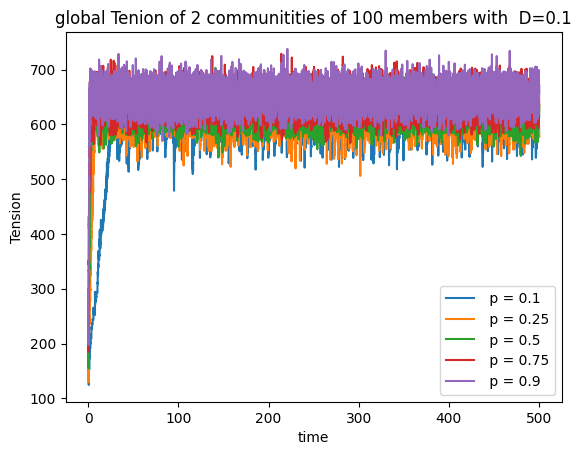

D 0.25 p 0.1
D 0.25 p 0.25
D 0.25 p 0.5
D 0.25 p 0.75
D 0.25 p 0.9


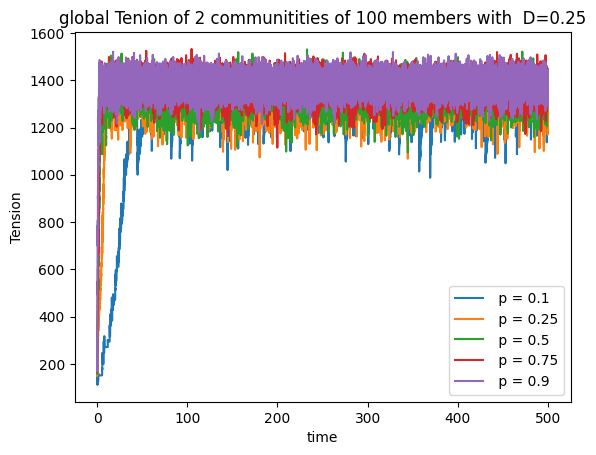

D 0.5 p 0.1
D 0.5 p 0.25
D 0.5 p 0.5
D 0.5 p 0.75
D 0.5 p 0.9


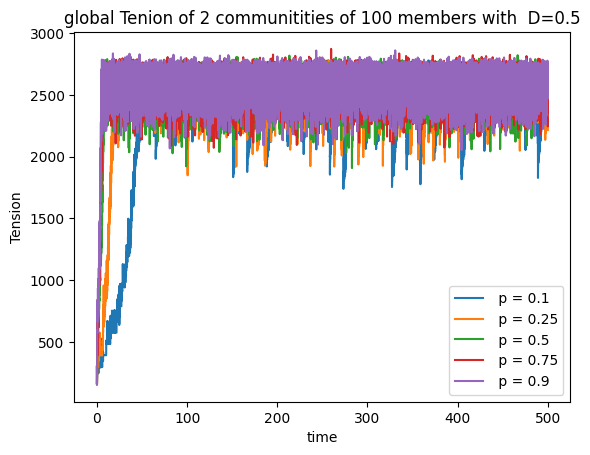

D 0.75 p 0.1
D 0.75 p 0.25
D 0.75 p 0.5
D 0.75 p 0.75
D 0.75 p 0.9


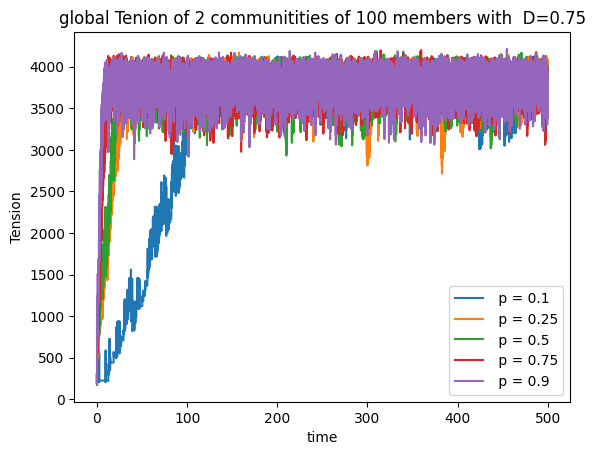

D 0.9 p 0.1
D 0.9 p 0.25
D 0.9 p 0.5
D 0.9 p 0.75
D 0.9 p 0.9


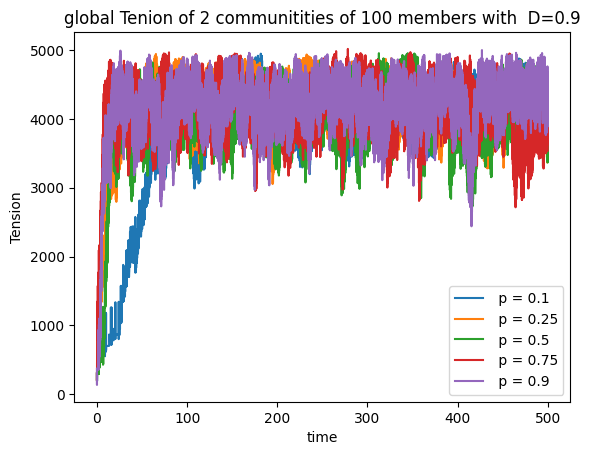

In [104]:
ComNet = ComDynaNet(100*2, 2)
A = 2
D_lst = [0.1,0.25,0.5,0.75,0.9]
p_lst = [0.1,0.25,0.5,0.75,0.9]
for D in D_lst:
    for p in p_lst:
        print('D',D, 'p', p)
        t0 = 0
        tf = 500
        nt = 50000
        init_value = 100
        def DE(Glap, Ggrad, f, D):
            '''
            GLag: graph Laplacian
            Ggrad: graph gradient
            f: state 
            D: vector ofdiffusion coefficient.
            v: velocity the tension is moving by.
            '''
            Dxf = np.multiply(D, f)
            gradf = np.dot(Ggrad, f)
            df = np.dot(Glap, Dxf) + np.multiply(f, 1-f)

            return df
        def DE_for_graph_withRf0(Glag, Ggrad, f, t):
            return DE(Glag, Ggrad, f, D) #+ np.random.normal(0, 0.5, size = len(f))
        t = np.linspace(t0, tf, nt)
        lbd = 1
        ComNet.Simulation_euler(DE_for_graph_withRf0, t0, tf, nt, lbd, init_value, p, D)

        plt.plot(t, ComNet.dynamic.sum(axis =0), label =' p = '+str(p))
    plt.xlabel('time')
    plt.ylabel('Tension')
    plt.legend()
    plt.title('global Tenion of 2 communitities of 100 members with  D=' + str(D) )
    plt.savefig('images/hiear_agg/D=' + str(D)+'.png')
    plt.show()
